# Figures 2-4

(_Adapted from `IBS_classes_2sexes_figures2and3.ipynb`_)

Code to produce main __Figures 2-4__ and __Supplementary Figures S9-S12__.

The simulation results used can be found in `RESULTS_FIG2-4` folder, which have been produced with the scripts:
- `SCRIPTS/script_fig2u4.py` for results used in Figure 2, Figure 4C-F and Supplementary Figures S9-S12
- `SCRIPTS/script_fig3u4.py` for results used in Figures 3 and Figure 4A-B

Refer to the scripts above for a detailed description on how the results were generation, and the content of each field.

In [1]:
# import required modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import timeit
import random
import os

# we will also use some functions in our own modules
import sys
sys.path.append('MODULES/')
from IBS_2sexes_simul_class import SimulatePopulation, Analytics
from IBS_2sexes_mutation_class import Mutation

In [2]:
# general functions

'''
We are considering 6 scenarios, differing in the magnitude and direction of shifts in sex-specific optima:
    - three in which only sexually-conconrdant adaptation occurs (Lambda_a>0, Lambda_d=0): 11, 22, 33
    - three in which only sexually-dimorphic adaptation occurs (Lambda_a=0, Lambda_d>0): 44, 55, 66
    
The difference between 11, 22 and 33 (44, 55 and 66) lies on the size of the shift in sex-specific optima (oi), where Lambda=oi\sqrt(2N):
    - small (11, 44): k=0.15
    - medium (22, 55): k=0.25
    - large (33, 66): k=0.5
'''

# These two functions get the (variance-scaled) shift size from the oi coefficient
def shift_size(oi):
    return oi*np.sqrt(2*1000)
    
def shift_size_va(oi):
    return oi*np.sqrt(2*1000)/np.sqrt(40)

# Function to get sex-specific optima from each of the 6 considered scenarios
def get_oFoM_fromScenario (scenario, oi=0):
    if scenario==11: ofi=0.15; omi=0.15
    elif scenario==22: ofi=0.25; omi=0.25
    elif scenario==33: ofi=0.50; omi=0.50
    elif scenario==44: ofi=0.15; omi=-0.15
    elif scenario==55: ofi=0.25; omi=-0.25
    elif scenario==66: ofi=0.50; omi=-0.50
    
    N=1000
    oF = float(ofi)*np.sqrt(2*N)
    oM = float(omi)*np.sqrt(2*N)
    
    if oi==1: return ofi, omi
    else: return oF, oM

# Fuction to load results
# NOTE: all simulations used here parametrize rfm in terms of q=1-rfm (for historical reasons in the project, which are not conceptually relevant anymore)
def open_file (scenario, rfm, E2Ns):
    # get q from rfm
    q = (1-rfm)
    # get sex-specific optima from scenario
    ofi, omi = get_oFoM_fromScenario (scenario, 1)
    # read data
    #path = '../CLUSTER/ANA10_24/RESULTS/'
    path = 'RESULTS_FIG2-4/'
    res = pd.read_csv(path+'ana10_WF_DF_1000N_10btN_10Ngen_200Reps_%.4fq_40VA_%iE2Ns_%.4foFi_%.4foMi_full_v1.csv'%(q,E2Ns,ofi,omi))
    return res

# Function to get aesthetics given parameters
def get_c_a (rfm, E2Ns):
    if E2Ns==1: a = 1 
    elif E2Ns==16: a = 1 
    if rfm==0.3: c = 'tab:red'
    elif rfm==0.5: c = 'tab:orange'
    elif rfm==0.7: c = 'tab:olive'
    elif rfm==0.8: c = 'tab:green'
    elif rfm==0.9: c = 'darkblue'
    elif rfm==0.95: c = 'darkblue'
    return c, a

# Function to initialize analytics for a particular VA
def initialize_analytics_fromVA (N, VA, rfm, E2Ns, oM=0, oF=0):
    q = (1-rfm)
    a0 = Analytics(N=N, U=0, optF=oM, optM=oM, q=q, E2Ns=E2Ns)
    # get mutation rate given variance
    U = a0.get_U_from_VA(VA)
    # initialize analytics with the given mutation rate
    analytics = Analytics(N=N, U=U, optF=oF, optM=oM, q=q, E2Ns=E2Ns)
    return analytics

In [3]:
'''
FUNCTION GROUP #1: run various types of semi-analytical phenotypic simulations, by updating D=[Df,Dm],
which corresponds to equation \ref{eq:DfDm} (Main Equation 46)
One can choose to display sex-specific averages,  Z=[zf,zm], or their distance from the optima D=[Df,Dm]
'''

'''This function updates D across generations given different variations of equation \ref{eq:DfDm}'''

def run_pheno_simulations_FM (scenario, rfm, E2Ns):

    '''This function updates D after single generation (corresponding to equation \ref{eq:DfDm}, 46)'''
    def deltaD_FM(D, W, G, mu3=None):
        deltaD = -np.matmul(G/W, D) *0.5 + mu3/(2*W)
        return deltaD

    '''This function updates D by using constant or generation-wise (from simulations) 2nd (G) and 3rd (mu3) central order moments
    of the phenotypic distribution, depending on the input:
        - if mu3=0 (default): constant 3rd central order moments at 0
        - else: use 3rd central order moments from simulations
        - if G is a list: use variances from simulations
        - else: use constant variance
    '''
    def runPhenoSimulations_FM (generations, D0, G, W, mu3=0):
        D=D0.copy()
        # fill in mu=0 if not given
        if type(mu3)==int: mu3=[0]*generations
        # if G is a list (updated generation-wise)
        if G.ndim==3:
            for i in range(generations):
                dD = deltaD_FM(D[-1], W, G[i], mu3[i])
                D += [D[-1]+dD]    
        # if G is a single matrix
        else:
            for i in range(generations):
                dD = deltaD_FM(D[-1], W, G, mu3[i])
                D += [D[-1]+dD]
        return np.array(D)
    
    #CURRENT FUNCTION
    
    # get simulation results, sex-specific optima and number of generations
    N=1000; VA=40
    res = open_file(scenario, rfm, E2Ns)
    oF, oM = get_oFoM_fromScenario (scenario, oi=0)
    oF, oM = get_oFoM_fromScenario (scenario)
    generations=len(res)
    
    # get initialD
    zF0=0; zM0=0
    Df = oF-zF0
    Dm = oM-zM0
    D0 = [np.array([Df,Dm])]    

    # get analytical G
    a = initialize_analytics_fromVA (N, VA, rfm, E2Ns)
    Vf=a.calculate_VA_f()
    Vm=a.calculate_VA_m()
    B = a.calculate_covar()
    Gana = np.array([[Vf,B],[B,Vm]])
    
    # get 2nd and 3rd central moments from simulations:
    # initial (G0) and updated (Glist) G matrix and 3rd moments
    VAfs = res.varF; VAms = res.varM; Bs = res.covar
    Glist = np.array([[[VAfs[i], Bs[i]],[Bs[i], VAms[i]]] for i in range(generations)])
    G0 = np.array([[VAfs[0], Bs[0]],[Bs[0], VAms[0]]])
    m3fm = np.array([res.m3F,res.m3M]).T

    # Get W matrix (which reduces to a signle Vs, since we're assuming that Vs=Vsf=Vsm)
    W = a.Vs

    # Run all types of 'phenotypic' simulations:
    
    # (type0) With mu3=0 and analytical G matrix
    Dt_Ga = runPhenoSimulations_FM(generations,D0,Gana,W)
    # (type1) With mu3=0 and G matrix corresponding to the initial covariance matrix obtained from simulations
    Dt_G0 = runPhenoSimulations_FM(generations,D0,G0,W)
    # (type2) With mu3 updated generation-wise from simulations and G matrix corresponding to the initial covariance matrix obtained from simulations
    Dt_G0m3t = runPhenoSimulations_FM(generations,D0,G0,W,m3fm)
    # (type3) With mu3=0 and G matrix updated generation-wise from simulations
    Dt_Gt = runPhenoSimulations_FM(generations,D0,Glist,W)
    # (type4) With mu3 and G matrix updated generation-wise from simulations
    Dt_Gtm3t = runPhenoSimulations_FM(generations,D0,Glist,W,m3fm)
    
    return Dt_Ga, Dt_G0, Dt_G0m3t, Dt_Gt, Dt_Gtm3t


''' This function runs all types of semi-analytical phenotypic simulations using run_pheno_simulations_FM
and plots the (desired subset of) simulation results'''

def plot_pheno_simul_FM (scenario, rfm, E2Ns, ax, which, ZorD):
    # run all types of simulations
    Dt_Ga, Dt_G0, Dt_G0m3t, Dt_Gt, Dt_Gtm3t = run_pheno_simulations_FM (scenario, rfm, E2Ns)
    # get sex-specific optima
    oF, oM = get_oFoM_fromScenario(scenario)
    # get aesthetics
    c, a = get_c_a(rfm, E2Ns)

    # choose if we want to display sex-specific averages,  Z=[zf,zm], or their distance from the optima D=[Df,Dm]
    if ZorD=='Z':
        Dt_Ga = np.array([oF,oM])-Dt_Ga
        Dt_G0 = np.array([oF,oM])-Dt_G0
        Dt_G0m3t = np.array([oF,oM])-Dt_G0m3t
        Dt_Gt = np.array([oF,oM])-Dt_Gt
        Dt_Gtm3t = np.array([oF,oM])-Dt_Gtm3t

    # choose which subset of semi-analytical simulations we want to plot
    if '0' in which: # (type0)
        ax.plot(Dt_Ga[:,0], c=c, alpha = 1, ls=':')#, label='GA noM3') 
        ax.plot(Dt_Ga[:,1], c=c, alpha = 0.5, ls=':') 
    if '1' in which: # (type1)
        ax.plot(Dt_G0[:,0], c=c, alpha = 1, ls=':')#, label='GA noM3') 
        ax.plot(Dt_G0[:,1], c=c, alpha = 0.5, ls=':') 
    if '2' in which: # (type2)
        ax.plot(Dt_G0m3t[:,0], c=c, alpha = 1, ls='-.')#, label='G0 M3') 
        ax.plot(Dt_G0m3t[:,1], c=c, alpha = 0.5, ls='-.') 
    if '3' in which: # (type3)
        ax.plot(Dt_Gt[:,0], c=c, alpha = 1, ls='--')#, label='Gn noM3') 
        ax.plot(Dt_Gt[:,1], c=c, alpha = 0.5, ls='--')
    if '4' in which: # (type4)
        # CHANGE THIS BETWEEN FIG 2 AND S1 (for different display of results)
        #ax.plot(Dt_Gtm3t[:,0], c=c, alpha = 1)#, label='Gn M3') 
        #ax.plot(Dt_Gtm3t[:,1], c=c, alpha = 0.5) 
        ax.plot(Dt_Gtm3t[:,0], c=c, alpha = 1, ls='--')#, label='Gn M3') 
        ax.plot(Dt_Gtm3t[:,1], c=c, alpha = 0.5, ls='--') 

''' This function plots Z or D from simulations, together with the desired subset of semi-analytical phenotypic simulations
indicated in the 'which' argument'''

def plot_zfzm (scenario, rfm, E2Ns, ax, which, ZorD):
    oF, oM = get_oFoM_fromScenario(scenario)
    if 's' in which:
        #load data
        res = open_file(scenario, rfm, E2Ns)
        c, a = get_c_a(rfm, E2Ns)
        if E2Ns==1: ls = 'solid'
        elif E2Ns==16: ls = 'solid'
        #plot empirical lines
        if ZorD=='Z':
            ax.plot(res.meanF, c=c, alpha=1, ls=ls)
            ax.plot(res.meanM, c=c, alpha=0.5, ls=ls)
            ax.fill_between(range(len(res)), res.meanF-1.96*res.meanF_se, res.meanF+1.96*res.meanF_se, color=c, alpha=0.7)
            ax.fill_between(range(len(res)), res.meanM-1.96*res.meanM_se, res.meanM+1.96*res.meanM_se, color=c, alpha=0.4)   
        elif ZorD=='D':
            ax.plot(oF-res.meanF, c=c, alpha=1, ls=ls) #c='tab:blue', ls=ls, lw=lw)
            ax.plot(oM-res.meanM, c=c, alpha=0.5, ls=ls) #c='tab:orange', ls=ls, lw=lw)
            ax.fill_between(range(len(res)), oF-res.meanF-1.96*res.meanF_se, oF-res.meanF+1.96*res.meanF_se, color=c, alpha=0.7)
            ax.fill_between(range(len(res)), oM-res.meanM-1.96*res.meanM_se, oM-res.meanM+1.96*res.meanM_se, color=c, alpha=0.4)
    
    plot_pheno_simul_FM(scenario, rfm, E2Ns, ax, which, ZorD)
    
    ax.axhline(y=oF, c='black', ls=':')
    ax.axhline(y=oM, c='black', ls=':')

In [4]:
'''
FUNCTION GROUP #2: run various types of semi-analytical phenotypic simulations, by updating D=[Da,Dd],
which corresponds to equation \ref{eq:DaDd} (Main Equation 47)
'''

'''This function updates D=[Da,Dd] across generations given different variations of equation \ref{eq:DfDm}'''

def run_pheno_simulations_AD (scenario, rfm, E2Ns):

    '''This function updates D after single generation (corresponding to equation \ref{eq:DaDd}, 47)'''
    def deltaD_AD(D, W, G, mu3=None):
        # these two work (for the right choice of W):
        #deltaD = -np.matmul( np.matmul(G, np.linalg.inv(W+G)), D) *0.5
        deltaD = -np.matmul(G/W, D) *0.5 + mu3/(2*W)
        return deltaD

    '''This function updates D by using constant or generation-wise (from simulations) 2nd (G) and 3rd (mu3) central order moments
    of the phenotypic distribution, depending on the input:
        - if mu3=0 (default): constant 3rd central order moments at 0
        - else: use 3rd central order moments from simulations
        - if G is a list: use variances from simulations
        - else: use constant variance'''
    def runPhenoSimulations_AD (generations, D0, G, W, mu3=0):
        D=D0.copy()
        # fill in mu if not given
        if type(mu3)==int: mu3=[0]*generations
        # if G is a list (generation-wise)
        if G.ndim==3:
            for i in range(generations):
                dD = deltaD_AD(D[-1], W, G[i], mu3[i])
                D += [D[-1]+dD]    
        # if G is a single matrix
        else:
            for i in range(generations):
                dD = deltaD_AD(D[-1], W, G, mu3[i])
                D += [D[-1]+dD]
        return np.array(D)
    
    #CURRENT FUNCTION
    
    # get simulation results, sex-specific optima and number of generations
    N=1000; VA=40
    res = open_file(scenario, rfm, E2Ns)
    oF, oM = get_oFoM_fromScenario (scenario)
    generations=len(res)

    # get initial D
    oA = 0.5*(oF+oM)
    oD = 0.5*(oF-oM)
    Da=oA-0
    Dd=oD-0
    D0 = [np.array([Da,Dd])]    

    # get analytical G matrix
    a = initialize_analytics_fromVA (N, VA, rfm, E2Ns)
    Va=a.calculate_Va()
    Vd=a.calculate_Vd()
    B = a.calculate_covar()
    Gana = np.array([[Va+B,Vd],[Vd,Va-B]])
    
    # get 2nd and 3rd central moments from simulations:
    # initial (G0) and updated (Glist) G matrix and 3rd moments
    VAas = res.Va; VAds = res.Vd; Bs = res.covar
    Glist = np.array([[[VAas[i]+Bs[i], VAds[i]],[VAds[i], VAas[i]-Bs[i]]] for i in range(len(res))])
    G0 = np.array([[VAas[0]+Bs[0], VAds[0]],[VAds[0], VAas[0]-Bs[0]]])
    m3ad = np.array([res.m3a,res.m3d]).T

    # Get W matrix (which reduces to a signle Vs, since we're assuming that Vs=Vsf=Vsm)
    W = a.Vs
    
    # Run all types of 'phenotypic' simulations:
    
    # (type0) With mu3=0 and analytical G matrix
    Dt_Ga = runPhenoSimulations_AD(generations,D0,Gana,W)
    # (type1) With mu3=0 and G matrix corresponding to the initial covariance matrix obtained from simulations
    Dt_G0 = runPhenoSimulations_AD(generations,D0,G0,W)
    # (type2) With mu3 updated generation-wise from simulations and G matrix corresponding to the initial covariance matrix obtained from simulations
    Dt_G0m3t = runPhenoSimulations_AD(generations,D0,G0,W,m3ad)
    # (type3) With mu3=0 and G matrix updated generation-wise from simulations
    Dt_Gt = runPhenoSimulations_AD(generations,D0,Glist,W)
    # (type4) With mu3 and G matrix updated generation-wise from simulations
    Dt_Gtm3t = runPhenoSimulations_AD(generations,D0,Glist,W,m3ad)    
    
    return Dt_Ga, Dt_G0, Dt_G0m3t, Dt_Gt, Dt_Gtm3t

''' This function runs all types of semi-analytical phenotypic simulations using run_pheno_simulations_SF
and plots the (desired subset of) simulation results'''

def plot_pheno_simul_AD (scenario, rfm, E2Ns, which, ax1=None, ax2=None, fig=None):
    
    # run all types of simulations
    Dt_Ga, Dt_G0, Dt_G0m3t, Dt_Gt, Dt_Gtm3t = run_pheno_simulations_AD (scenario, rfm, E2Ns)
    # get aesthetics given parameters
    c,a = get_c_a(rfm, E2Ns)
    
    # choose which subset of semi-analytical simulations we want to plot
    if '0' in which: # (type0)
        ax.plot(Dt_Ga[:,0], c=c, alpha = 1, ls=':')#, label='GA noM3') 
        ax.plot(Dt_Ga[:,1], c=c, alpha = 0.5, ls=':') 
    if '1' in which: # (type1)
        if ax1 is not None: ax1.plot(Dt_G0[:,0], c=c, ls=':')#, label='-') 
        if ax2 is not None: ax2.plot(Dt_G0[:,1], c=c, ls=':', label=r"Constant $G'$, $\mu_{3,a}=\mu_{3,d}=0$") #label='-')  
    if '2' in which: # (type2)
        if ax1 is not None: ax1.plot(Dt_G0m3t[:,0], c=c, ls='-.')#, label=r'$m_3$') 
        if ax2 is not None: ax2.plot(Dt_G0m3t[:,1], c=c, ls='-.', label=r"Constant $G'$, $\mu_{3,a}(t), \mu_{3,d} (t)$") #label=r'$m_3$')  
    if '3' in which: # (type3)
        if ax1 is not None: ax1.plot(Dt_Gt[:,0], c=c, ls='--')#, label=r'$m_2$') 
        if ax2 is not None: ax2.plot(Dt_Gt[:,1], c=c, ls='--', label=r"$G'(t), \mu_{3,a}=\mu_{3,d}=0$") #label=r'$m_2$') 
    if '4' in which:  # (type4)
        # aesthetics change between fig2 and S1
        if fig=='S1':
            if ax1 is not None: ax1.plot(Dt_Gtm3t[:,0], c=c)#, label=r'$m_2, m_3$') 
            if ax2 is not None: ax2.plot(Dt_Gtm3t[:,1], c=c, label=r"$G'(t), \mu_{3,a}(t), \mu_{3,d} (t)$") #label=r'$m_2, m_3$') 
        if fig=='2':
            if ax1 is not None: ax1.plot(Dt_Gtm3t[:,0], c=c, ls='--')
            if ax2 is not None: ax2.plot(Dt_Gtm3t[:,1], c=c, ls='--') 

''' This function plots Z or D from simulations, together with the desired subset of semi-analytical phenotypic simulations
indicated in the 'which' argument'''

def plot_DaDd (scenario, rfm, E2Ns, which, axDa=None, axDd=None, fig=None):
    if 's' in which:
        # load data
        res = open_file(scenario, rfm, E2Ns)
        # get aesthetics
        c, a = get_c_a(rfm, E2Ns)
        a1 = 1; a2 = 0.4 
        #plot empirical lines
        lab=''
        if fig=='S2':
            if E2Ns==1: a1=0.4; a2= 0.3; lab='Approx. infinitesimal'
            elif E2Ns==16: a1=1; a2=0.7; lab='Multigenic'
        if axDa is not None: 
            if fig=='S2':
                if E2Ns==16: 
                    axDa.plot(res.Da, c=c, alpha=a1, label='%.2f'%(rfm))
                else: axDa.plot(res.Da, c=c, alpha=a1)
            else: axDa.plot(res.Da, c=c, alpha=a1, label='%.2f'%(rfm))
            axDa.fill_between(range(len(res)), res.Da-1.96*res.Da_se, res.Da+1.96*res.Da_se, color=c, alpha=a2)
        if axDd is not None:
            if fig=='S1': lab=r'$D_a$ or $D_d$'
            axDd.plot(res.Dd, c=c, alpha=a1, label=lab)#, label=1-q) #c='tab:orange', ls=ls, lw=lw)
            axDd.fill_between(range(len(res)), res.Dd-1.96*res.Dd_se, res.Dd+1.96*res.Dd_se, color=c, alpha=a2)   

    # plot the semi-analytical simulation results
    plot_pheno_simul_AD(scenario, rfm, E2Ns, which, axDa, axDd, fig)
    
    # plot the analytical results
    if 'a' in which:
        plot_DatDdt(scenario, rfm, E2Ns, axDa, axDd)


'''These functions update D along time using the analytical approximation under infinitesimal assumption,
corresponding to equation \ref{eq:dadd} (main Equation 42)'''

# Analytical Da along time
def expected_Dat (generations, oA, Va, B, Vs):
    
    def Dat (Delta_a, Va, B, Vs, t): return Delta_a* np.exp(-(Va+B)/(2*Vs)*t)
    Dats = [Dat(oA, Va,B,Vs, i) for i in range(generations)]
    return Dats

# Analytical Dd along time
def expected_Ddt (generations, oD, Va, B, Vs):
    
    def Ddt (Delta_d, Va, B, Vs, t): return Delta_d* np.exp(-(Va-B)/(2*Vs)*t)
    Ddts = [Ddt(oD, Va,B,Vs, i) for i in range(generations)]
    return Ddts

# Get and plot analytical Da, Dt along time

def plot_DatDdt(scenario, rfm, E2Ns, axDa, axDd):
    # load simulation results
    res = open_file(scenario, rfm, E2Ns)
    # get average and average distance optima
    oF, oM = get_oFoM_fromScenario (scenario, oi=0)
    oA = 0.5*(oF+oM)
    oD = 0.5*(oF-oM)
    # set basic parameters
    generations = len(res)
    N = 1000; VA = 40; 
    # get parameters from the analytics
    a = initialize_analytics_fromVA (N, VA, rfm, E2Ns)
    Va = a.calculate_Va()
    B = a.calculate_covar()
    Vs = a.Vs
    # Get Da, Dt along time
    Dat = expected_Dat (generations, oA, Va, B, Vs)
    Ddt = expected_Ddt (generations, oD, Va, B, Vs)
    # plot them
    if axDa is not None: axDa.plot(Dat, c='black', ls='dashed', lw=3, alpha=0.5)#, label='Inf')
    if axDd is not None: axDd.plot(Ddt, c='black', ls='dashed', lw=3, alpha=0.5, label='Infinitesimal limit') #label='Inf')
    

In [5]:
'''
FUNCTION GROUP #3: plot the fixed backgrounds Fa, Fd,
which corresponds to equation \ref{eq:DaDd} (Main Equation 47)
'''

def plot_FaFd (scenario, rfm, E2Ns, which, axFa=None, axFd=None):
    # load simulation results
    res = open_file(scenario, rfm, E2Ns)
    # get optima from scenario
    oF, oM = get_oFoM_fromScenario (scenario, oi=0)
    oA = 0.5*(oF+oM)
    oD = 0.5*(oF-oM)
    
    # plot Fa,Fd from simulations 
    if 's' in which:
        c, a = get_c_a(rfm, E2Ns)
        if axFa is not None:
            axFa.plot(res.Fa, c=c, alpha=a) #c='tab:blue', ls=ls, lw=lw)
            axFa.fill_between(range(len(res)), res.Fa-1.96*res.Fa_se, res.Fa+1.96*res.Fa_se, color=c, alpha=0.4)
        if axFd is not None:
            axFd.plot(res.Fd, c=c, alpha=a) #c='tab:orange', ls=ls, lw=lw)
            axFd.fill_between(range(len(res)), res.Fd-1.96*res.Fd_se, res.Fd+1.96*res.Fd_se, color=c, alpha=0.4) 

    # plot analytical Fa,Fd
    if 'a' in which:
        # get analytical Fa,Fd
        Ftsa, Ftsd = expected_Ft(len(res), 1000, oA, oD)
        # plot them
        if rfm==0.5:
            if axFa is not None: axFa.plot(Ftsa, c='black', ls='--', label=r'$\Lambda_a \;e^{-t/(2N)}$')
            if axFd is not None: axFd.plot(Ftsd, c='black', ls='--', label=r'$\Lambda_d \;e^{-t/(2N)}$')
        else:
            if axFa is not None: axFa.plot(Ftsa, c='black', ls='--')
            if axFd is not None: axFd.plot(Ftsd, c='black', ls='--')

'''Function to compute the analytical prediction for Fa, Fd,
corresponding to Equations \ref{eq:Fa} (49) and \ref{eq:Fa} (50)'''

def expected_Ft (generations, N, oA, oD):
    
    def Ft (Delta, N, t): return Delta*np.exp(-t/(2*N))
    Ftsa = [Ft(oA, N, i) for i in range(generations)]
    Ftsd = [Ft(oD, N, i) for i in range(generations)]
    return Ftsa, Ftsd 


# Figure 2

Phenotypic dynamics with approximately infinitesimal (top) and multigenic (bottom) genetic architecture

In [6]:
'''Functions to plot the results using the functions above, nothing very mysterious'''

def plot_zfzm_allrfms (scenario, E2Ns, ax):
    plot_zfzm(scenario, rfms[0], E2Ns, ax, 's4', 'Z')
    plot_zfzm(scenario, rfms[1], E2Ns, ax, 's4', 'Z')
    plot_zfzm(scenario, rfms[2], E2Ns, ax, 's4', 'Z')

def plot_DaDd_allrfms (scenario, E2Ns, axDa=None, axDd=None, fig='2'):
    plot_DaDd(scenario=scenario, rfm=rfms[0], E2Ns=E2Ns, which='s4', axDa=axDa, axDd=axDd, fig=fig)
    plot_DaDd(scenario=scenario, rfm=rfms[1], E2Ns=E2Ns, which='s4', axDa=axDa, axDd=axDd, fig=fig)
    plot_DaDd(scenario=scenario, rfm=rfms[2], E2Ns=E2Ns, which='s4', axDa=axDa, axDd=axDd, fig=fig)

def plot_FaFd_all (scenario, E2Ns, axa, axd):
    plot_FaFd(scenario, rfms[0], E2Ns, 'as', axa, axd)
    plot_FaFd(scenario, rfms[1], E2Ns, 'as', axa, axd)
    plot_FaFd(scenario, rfms[2], E2Ns, 'as', axa, axd)

# Function to plot the results for concordant adaptation, with Lambda_d=0

def plt_concordant (s1):
    plot_zfzm_allrfms (s1, 1, ax1)
    plot_zfzm_allrfms (s1, 16, ax4)
    plot_DaDd_allrfms (scenario=s1, E2Ns=1, axDa=ax2, axDd=None)
    plot_DaDd_allrfms (scenario=s1, E2Ns=16, axDa=ax5, axDd=None)
    plot_FaFd_all(scenario=s1, E2Ns=1, axa=ax3, axd=None)
    plot_FaFd_all(scenario=s1, E2Ns=16, axa=ax6, axd=None)
    ax1.set_title(r'$\bar z_f, \bar z_m$', fontsize=20)
    ax2.set_title(r'$D_a$', fontsize=20)
    ax3.set_title(r'$F_a$', fontsize=20)
    ax1.set_ylabel('Approximately\ninfinitesimal', fontsize=20)
    ax4.set_ylabel('Multigenic', fontsize=20)
    [ax.set_xlim(-10,500) for ax in [ax1,ax2]]
    ax2.legend(fontsize=15, title=r'$r_{fm}$', title_fontsize=15, bbox_to_anchor=(0.9, 1))
    [ax.legend(fontsize=18, bbox_to_anchor=(0.9, 1)) for ax in [ax3,ax6]]
    [ax.axhline(y=0, c='black', ls=':') for ax in [ax2,ax3,ax5,ax6]]
    [ax.tick_params(labelsize=16) for ax in [ax1,ax2,ax3,ax4,ax5,ax6]];
    ax5.set_xlabel('Time (generations)', fontsize=20)

# Function to plot the results for dimorphic adaptation, with Lambda_a=0

def plt_dimorphic (s2):
    [ax.axhline(y=shift_size(0.25)*(1-0.5), c='tab:purple', ls=':', lw=2) for ax in [ax2,ax5]]
    [ax.axhline(y=shift_size(0.25)*(1-0.8), c='tab:brown', ls=':', lw=2) for ax in [ax2,ax5]]
    [ax.axhline(y=shift_size(0.25)*(1-0.95), c='tab:olive', ls=':', lw=2) for ax in [ax2,ax5]]
    plot_zfzm_allrfms (s2, 1, ax1)
    plot_zfzm_allrfms (s2, 16, ax4)
    plot_DaDd_allrfms (scenario=s2, E2Ns=1, axDa=None, axDd=ax2)
    plot_DaDd_allrfms (scenario=s2, E2Ns=16, axDa=None, axDd=ax5)
    plot_FaFd_all(scenario=s2, E2Ns=1, axa=None, axd=ax3)
    plot_FaFd_all(scenario=s2, E2Ns=16, axa=None, axd=ax6)
    ax1.set_title(r'$\bar z_f, \bar z_m$', fontsize=20)
    ax2.set_title(r'$D_d$', fontsize=20)
    ax3.set_title(r'$F_d$', fontsize=20)
    ax1.set_ylabel('Approximately\ninfinitesimal', fontsize=20)
    ax4.set_ylabel('Multigenic', fontsize=20)
    [ax.legend(fontsize=18, bbox_to_anchor=(0.9, 1)) for ax in [ax3,ax6]]
    [ax.axhline(y=0, c='black', ls=':') for ax in [ax2,ax3,ax5,ax6]]
    [ax.tick_params(labelsize=16) for ax in [ax1,ax2,ax3,ax4,ax5,ax6]];
    ax5.set_xlabel('Time (generations)', fontsize=20)

## Figure 2 A-F

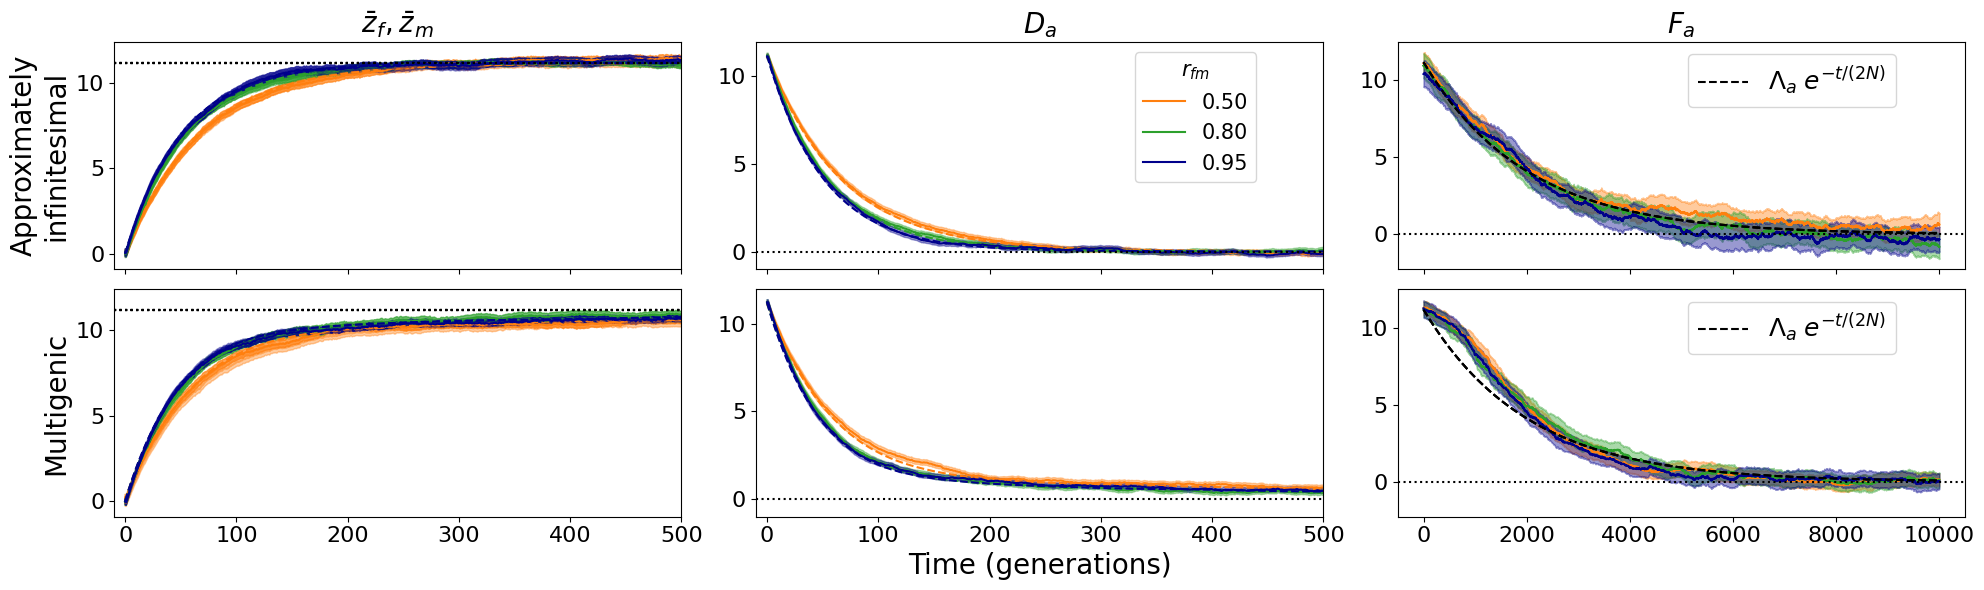

In [7]:
f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,6), sharex='col', sharey='col')

# Scenario 22 (concordant adaptation with medium shift size)
s1 = 22
# for three rfm values
rfms=[0.5,0.8,0.95]

plt_concordant (s1)

f.tight_layout()

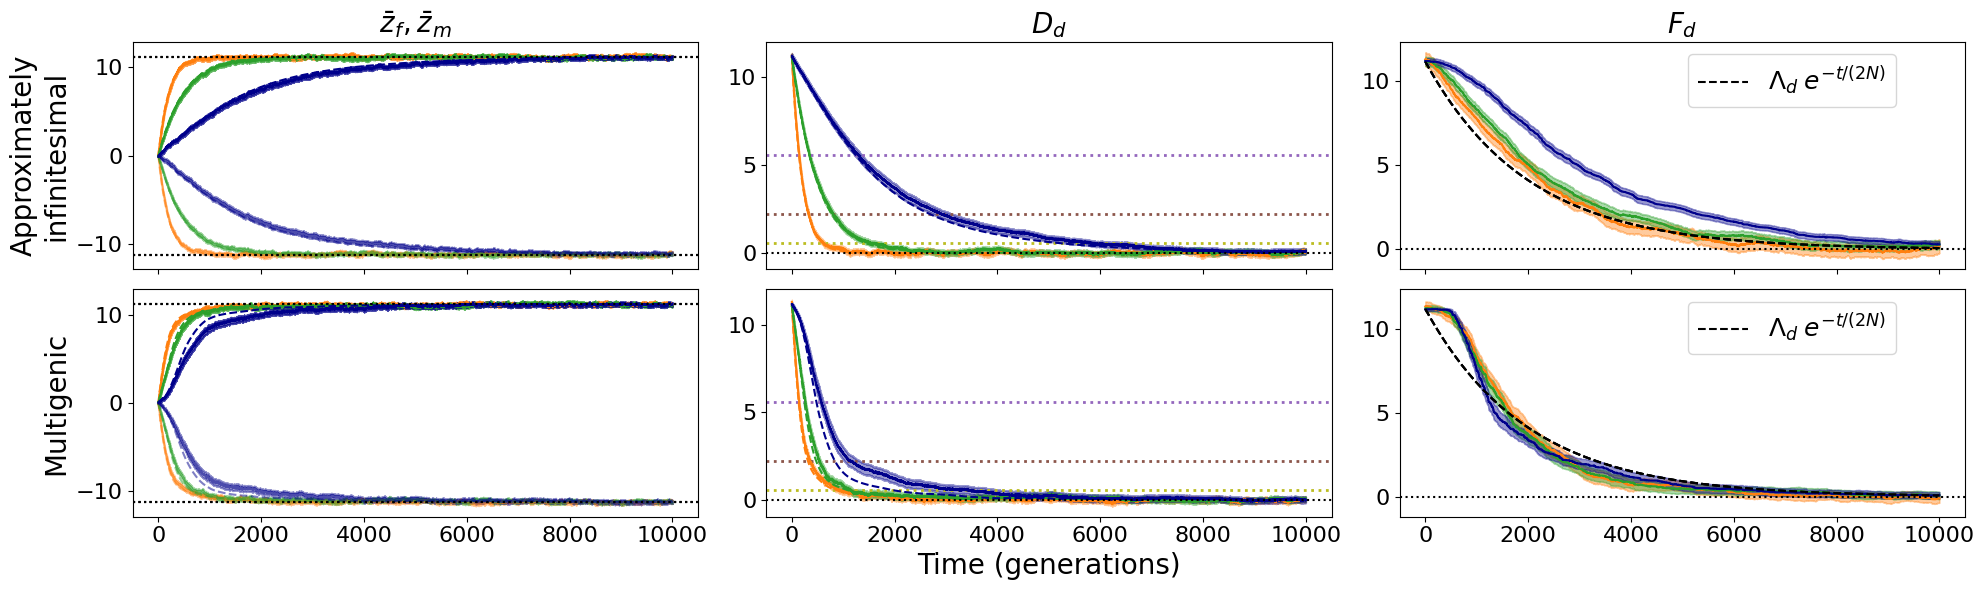

In [8]:
f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,6), sharex='col', sharey='col')

# Scenario 55 (dimorphic adaptation with medium shift size)
s2 = 55
# for three rfm values
rfms=[0.5,0.8,0.95]

plt_dimorphic (s2)

f.tight_layout()

## Figure 2G

Difference in dimorphic adaptation timescale between infinitesimal and multigenic architectures

In [9]:
'''Functions to plot the time it takes for dimorphic adaptation with an approximately infinitesimal
and multigenic genetic architectures and for various intersex correlation values,
analytically and from simulations. The functions are techncially calculating the time it takes for Dd to reach a
certain percentage of the initial value (before the shift), which exactly corresponds to the time it takes for $SD_{pm}$
to reach that same percentage.'''

'''Function to get the ANALYTICAL time it takes for Da, Dd reach a particular value, parametrized with 'k'
(corresponding to Equation \ref{eq:tatd}, 43)
we typically want to know how long it takes for D to reach k=delta, which determines the end of the rapid phase and beginning
of equilibration, but it can be used for any value -- as we do here'''

def get_ta_td_analytical (scenario, rfm, E2Ns, k):
    # get sex-specific optima from scenario
    oF,oM = get_oFoM_fromScenario (scenario)
    # average and average difference optima
    oA = 0.5*(oF+oM)
    oD = 0.5*(oF-oM)
    # get analytical parameters
    a = initialize_analytics_fromVA (1000, 40, rfm, E2Ns)
    Va = a.calculate_Va()
    B = a.calculate_covar()
    Vs = a.Vs

    # apply function \ref{eq:tatd} to get the times to reach k
    ta=0; td=0
    if oA!=0: ta = 2*Vs/(Va+B) * (np.log(oA) - np.log(k))
    if oD!=0: td = 2*Vs/(Va-B) * (np.log(oD) - np.log(k))
    
    return ta, td

'''Function to plot the analytical time for Dd to be reduced to a particular percentage of the initial value.
Argument ati takes that percentage'''

def plot_td_analytical (ati, ax):
    # the value of Dd corresponding to ati
    at = shift_size(0.25)-shift_size(0.25)*ati
    ls, c, ms = get_aesth (1, ati)
    # get the analytical time (with an approximately infinitesimal genetic architecture)
    td_analytical = []
    for r in np.linspace(0.0,0.95):
        _, a = get_ta_td_analytical (55, r, 1, at)
        td_analytical += [a]
    # plot
    ax.plot(np.linspace(0,0.95), td_analytical, c=c, label=int(ati*100))   

'''Function to get and plot the EMPIRICAL time taken to reach a particular percentage of Dd (ati)'''

def plot_td_empirical (ati, E2Ns, ax):
    # get aesthetics
    ls, c, ms = get_aesth (E2Ns, ati)
    td_empirical = []
    ci_empirical = []
    # get the value of Dd corresponding to ati
    at = shift_size(0.25)-shift_size(0.25)*ati
    # for all these values of rfms
    rfms = [0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
    for rfm in rfms:
        # get simluation results
        df = open_file (55, rfm, E2Ns)
        # get all the indices (corresponding to time in generations) in which Dd is within a range of 'at'
        # (the range corresponds to +-0.2, which is an arbitrary threshold)
        l = df.loc[((df.Dd < at+0.2) & (df.Dd > at-0.2)), 'sampledtimes']
        # get average time (and 95%CI)
        td_empirical += [np.mean(l)]
        ci_empirical += [1.96*np.std(l)] #[1.96*np.mean(df.iloc[l].Dd_se)]
    # plot results
    ax.errorbar(rfms, td_empirical, yerr = ci_empirical, fmt='o', ls='none', c=c, mfc=ms, markersize=8, lw=2)

# Plot analytical and empirical results
def plot_td_all (ati, ax):
    plot_td_empirical (ati, 16, ax)
    plot_td_empirical (ati, 1, ax)
    plot_td_analytical (ati, ax)

# Aesthetics of this particular subplot
def get_aesth (E2Ns, ati):
    if ati == 0.3: c = 'tab:grey'
    elif ati == 0.5: c = 'tab:purple'
    elif ati == 0.8 : c = 'tab:brown'
    elif ati == 0.95 : c = 'tab:olive'
    if E2Ns == 1: ls = 'solid'; ms = c
    elif E2Ns == 16: ls = 'dashed'; ms = 'white'
    return ls, c, ms

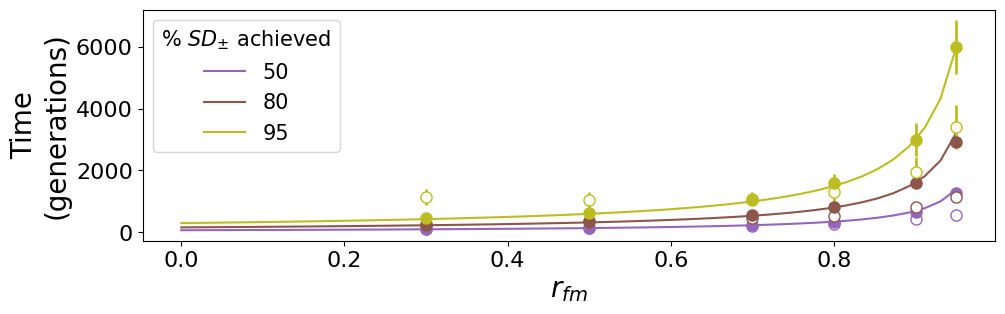

In [10]:
f, ax = plt.subplots(1, figsize=(11,3))

plot_td_all (0.5, ax)
plot_td_all (0.8, ax)
plot_td_all (0.95, ax)

ax.set_xlabel(r'$r_{fm}$', fontsize=20)
ax.set_ylabel('Time\n(generations)', fontsize=20)
ax.tick_params(labelsize=16) 
ax.legend(fontsize=15, title='% $SD_{\pm}$ achieved', title_fontsize=15, loc=2);

# Figure S10

Phenotypic dynamics with a multigenic genetic architecture.

We are displaying the results for the various types of semi-analytical phenotypic simulations (for more details check FUNCTION GROUP #2 above).  

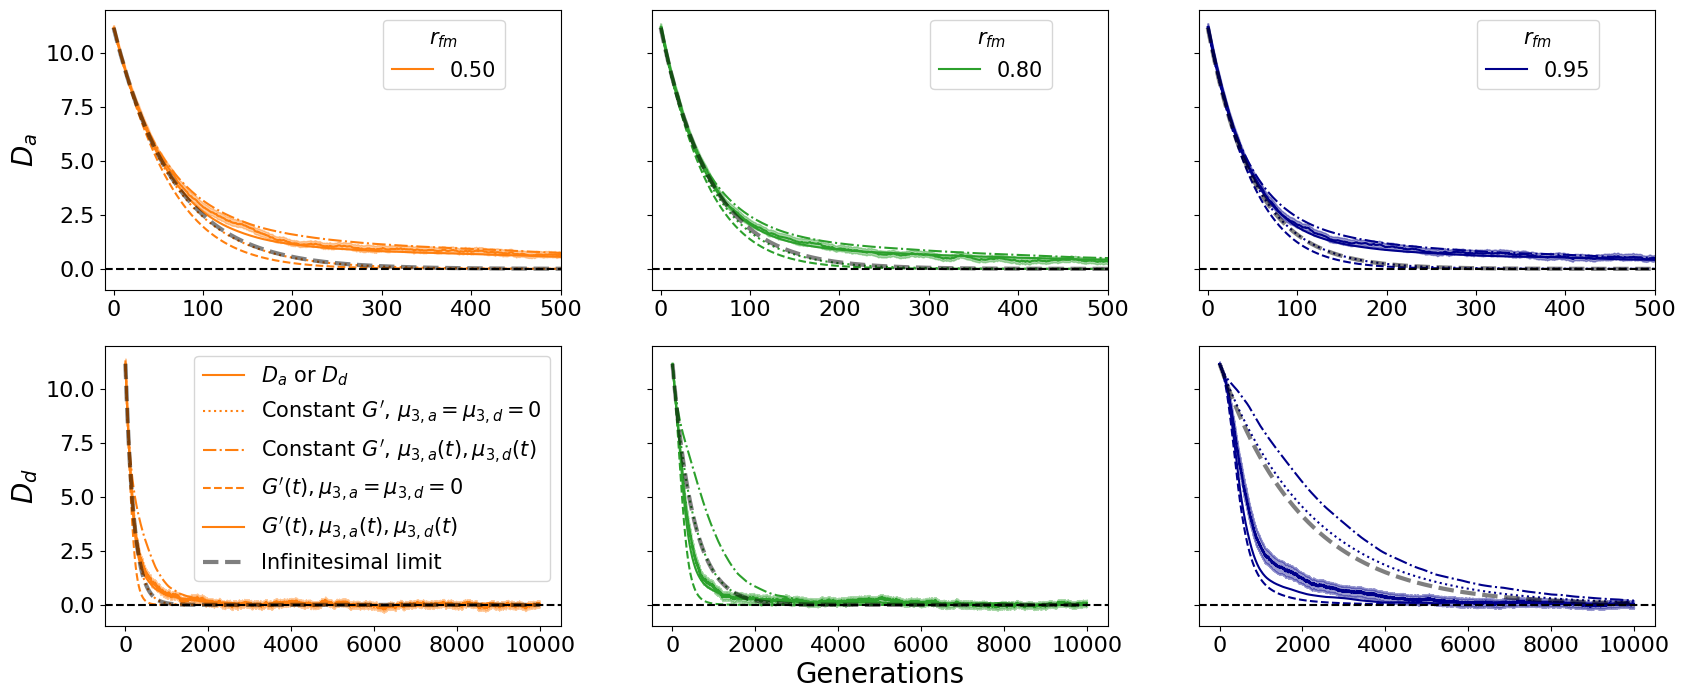

In [11]:
f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,8), sharey=True)

# multigenic genetic architecture
E2Ns = 16
# we are showing all the results
which = 's1234a'
#which = 'sa' #but one can play with 'which' argument to see less results

# for scenarios 22 and 55 (medium shift sizes)
s1 = 22
s2 = 55
# for three rfm values
rfms = [0.5, 0.8, 0.95]

# concordant adaptation
plot_DaDd(scenario=s1, rfm=rfms[0], E2Ns=E2Ns, which=which, axDa=ax1, axDd=None, fig='S1')
plot_DaDd(scenario=s1, rfm=rfms[1], E2Ns=E2Ns, which=which, axDa=ax2, axDd=None, fig='S1')
plot_DaDd(scenario=s1, rfm=rfms[2], E2Ns=E2Ns, which=which, axDa=ax3, axDd=None, fig='S1')
# dimorphic adaptation
plot_DaDd(scenario=s2, rfm=rfms[0], E2Ns=E2Ns, which=which, axDa=None, axDd=ax4, fig='S1')
plot_DaDd(scenario=s2, rfm=rfms[1], E2Ns=E2Ns, which=which, axDa=None, axDd=ax5, fig='S1')
plot_DaDd(scenario=s2, rfm=rfms[2], E2Ns=E2Ns, which=which, axDa=None, axDd=ax6, fig='S1')
    

[ax.set_xlim(-10,500) for ax in [ax1,ax2,ax3]];

ax1.set_ylabel(r'$D_a$', fontsize=20)
ax4.set_ylabel(r'$D_d$', fontsize=20)
ax5.set_xlabel('Generations', fontsize=20)

[ax.legend(fontsize=15, title=r'$r_{fm}$', title_fontsize=15, bbox_to_anchor=(0.9, 1)) for ax in [ax1,ax2,ax3]]
ax4.legend(fontsize=15, loc=1) #bbox_to_anchor=(0.9, 1))
[ax.tick_params(labelsize=16) for ax in [ax1,ax2,ax3,ax4,ax5,ax6]];

[ax.axhline(y=0, c='black', ls='--') for ax in [ax1,ax2,ax3,ax4,ax5,ax6]];

# Figure S11
The quasi-static approximation

In [12]:
'''Functions to plot the quasi-static approximation, derived in Suppplementary Section 8.1'''

# Function to plot the quasi-stataic approximation
def plot_quasistatic (scenario, rfm, E2Ns, axa=None, axd=None):
    
    # load simulation results
    res = open_file(scenario, rfm, E2Ns)
    
    # remove outliers to ease visualization
    # Dta and Dtd correspond to Equations S.54
    Dta = [np.nan if abs(i) >10 else i for i in res.Dta]
    Dtd = [np.nan if abs(i) >10 else i for i in res.Dtd]
    # Dt2a and Dt2d correspond to Equations S.55
    Dt2a = [np.nan if abs(i) >10 else i for i in res.Dt2a]
    Dt2d = [np.nan if abs(i) >10 else i for i in res.Dt2d]

    #get aesthetics
    c,a = get_c_a (rfm, E2Ns)
    
    if axa is not None:
        #axa.plot(Dta, c='red', label='Dta', ls='dashed')
        #axa.fill_between(range(len(res)), Dta-1.96*res.Dta_se, Dta+1.96*res.Dta_se, color='red', alpha=0.5)
        axa.plot(Dt2a, alpha=1, c='black')#, label='Dt2a')
        axa.fill_between(range(len(res)), Dt2a-1.96*res.Dt2a_se, Dt2a+1.96*res.Dt2a_se, color='black', alpha=0.8)
        #axa.legend()
    if axd is not None:
        #axd.plot(Dtd, c='red', label='Dtd', ls='dashed')
        #axd.fill_between(range(len(res)), Dtd-1.96*res.Dtd_se, Dtd+1.96*res.Dtd_se, color='red', alpha=0.5)
        axd.plot(Dt2d, alpha=1, c='black', label='Quasi-static approx.')
        axd.fill_between(range(len(res)), Dt2d-1.96*res.Dt2d_se, Dt2d+1.96*res.Dt2d_se, color='black', alpha=0.8)
        #axd.legend()

# Function to plot the quasi-static approximation together with Da, Dd at the equilibration phase
def quasi_static_approx (scenario, rfm, E2Ns, axa=None, axd=None):
    res = open_file(scenario, rfm, E2Ns)
    plot_quasistatic(scenario, rfm, E2Ns, axa, axd)
    
    which = 'sa'
    plot_DaDd (scenario, rfm, E2Ns, which, axa, axd, 'S2')
    plot_DaDd (scenario, rfm, 1, which, axa, axd, 'S2')
    
    ta, td = get_ta_td_analytical(scenario, rfm, E2Ns, 1)
    c,a = get_c_a (rfm, E2Ns)
    if axa is not None: axa.axvline(x=ta, c=c, ls='--')
    if axd is not None: axd.axvline(x=td, c=c, ls='--')
        
# Times until Da, Dd reach delta, which determine the end of the rapid phase and beginning of equilibration
# (corresponding to Equation \ref{eq:tatd}, 43)
def get_times_for_plot (s1, s2, rfm):
    ta, _ = get_ta_td_analytical(s1, rfm, 16, 1)
    _, td = get_ta_td_analytical(s2, rfm, 16, 1)
    return ta, td

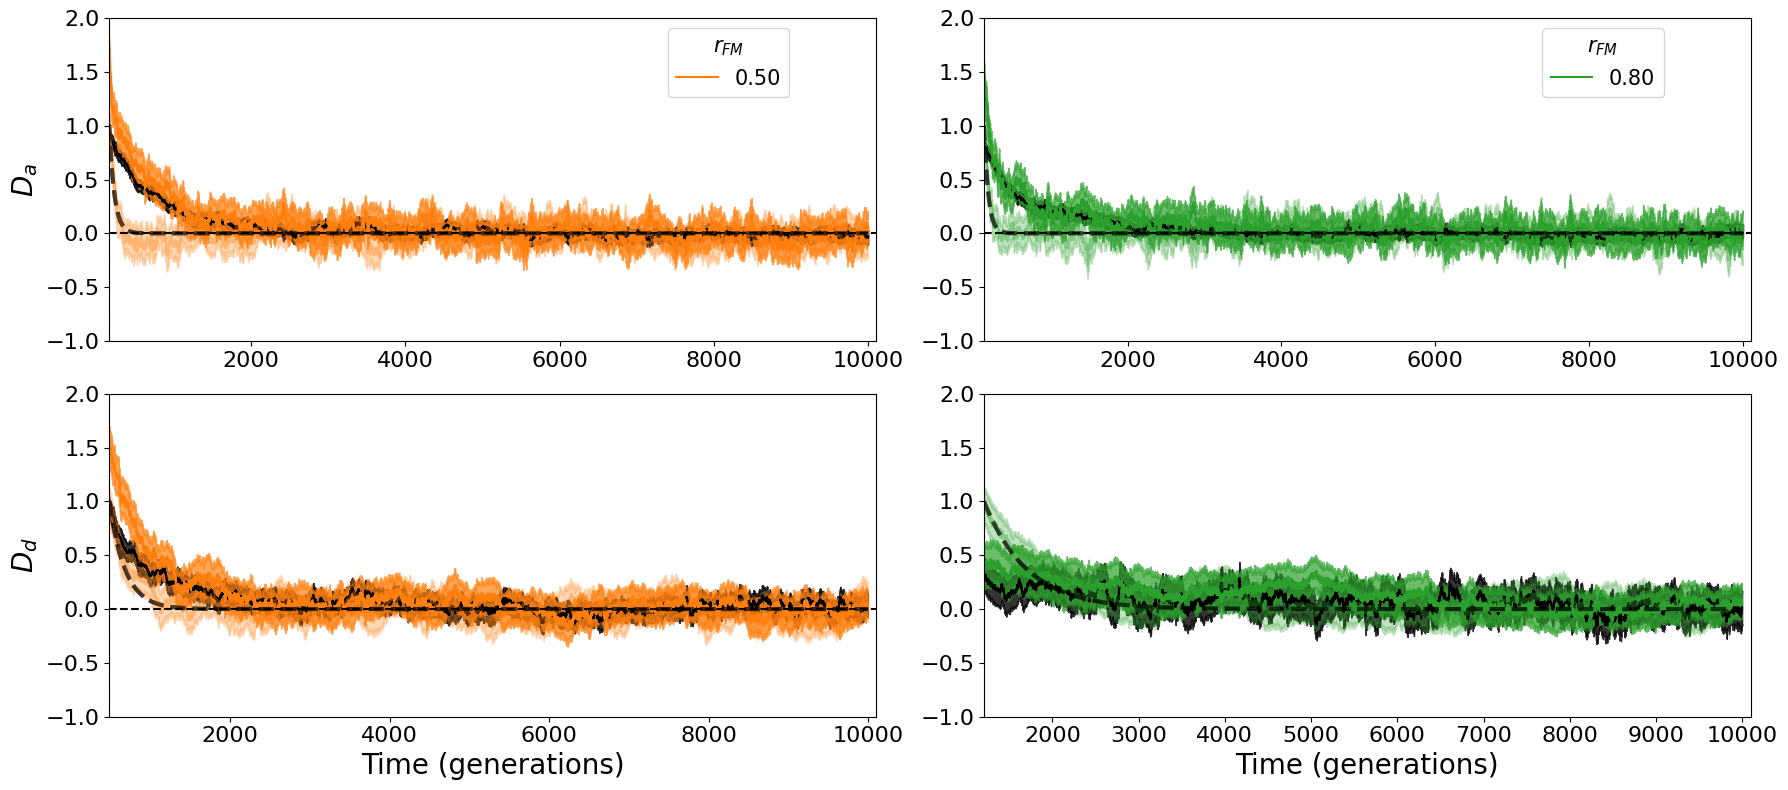

In [13]:
f, ((ax1,ax2),(ax4,ax5)) = plt.subplots(2,2, figsize=(18,8))

# Scenarios: concordant (22) and dimorphic (55) adaptation with medium shift sizes
s1 = 22
s2 = 55

def plot_quasi_static_approx (s1, s2, rfm, axa, axd):
    quasi_static_approx (scenario=s1, rfm=rfm, E2Ns=16, axa=axa, axd=None)
    quasi_static_approx (scenario=s2, rfm=rfm, E2Ns=16, axa=None, axd=axd)
    ta, td = get_times_for_plot (s1, s2, rfm)
    axa.set_xlim(ta,10100)
    axd.set_xlim(td,10100)

plot_quasi_static_approx (s1, s2, 0.5, ax1, ax4)
plot_quasi_static_approx (s1, s2, 0.8, ax2, ax5)

[ax.set_ylim(-1,2) for ax in [ax1,ax2,ax3,ax4,ax5,ax6]]
[ax.axhline(y=0, c='black', ls='--') for ax in [ax1,ax2,ax3,ax4]]

ax1.set_ylabel(r'$D_a$', fontsize=20)
ax4.set_ylabel(r'$D_d$', fontsize=20)
[ax.set_xlabel('Time (generations)', fontsize=20) for ax in [ax4,ax5,ax6]]

[ax.tick_params(labelsize=16) for ax in [ax1,ax2,ax3,ax4,ax5,ax6]];

[ax.legend(fontsize=15, title=r'$r_{FM}$', title_fontsize=15, bbox_to_anchor=(0.9, 1)) for ax in [ax1,ax2,ax3]];
ax3.legend(fontsize=13)
f.tight_layout()

________

# Evolution of 2nd and 3rd central order moments

Evolution of 2nd and 3rd central moments during aptation under directional selection

In [16]:
'''Functions to plot 2nd and 3rd order central moments'''

# Function to plot V_a and V_d
def plot_VaVd (scenario, rfm, E2Ns, axa=None, axd=None):
    # load simulation results
    res = open_file(scenario, rfm, E2Ns) 
    # get aesthetics
    c, a = get_c_a(rfm, E2Ns)
    if E2Ns==16: a1=1; a2=0.6
    elif E2Ns==1: a1=0.4; a2=0.2
    # initialyze analytics
    N = 1000; VA = 40; 
    a = initialize_analytics_fromVA (N, VA, rfm, E2Ns)
    #plot empirical lines
    if axa is not None:
        axa.plot(res.Va, c=c, alpha=a1)
        axa.fill_between(range(len(res)), res.Va-1.96*res.Va_se, res.Va+1.96*res.Va_se, color=c, alpha=a2) 
        axa.axhline(y=a.calculate_Va(), c='tab:blue', ls='--')
    if axd is not None:
        axd.plot(res.Vd, c=c, alpha=a1)
        axd.fill_between(range(len(res)), res.Vd-1.96*res.Vd_se, res.Vd+1.96*res.Vd_se, color=c, alpha=a2)
        axd.axhline(y=a.calculate_Vd(), c='tab:orange', ls='--')

# Function to plot V_a contributed by shared or sex-specific mutations
def plot_Va_sharedspec (sharedspec, scenario, rfm, E2Ns, ax):
    # load simulation results
    res = open_file(scenario, rfm, E2Ns) 
    # get aesthetics
    c, a = get_c_a(rfm, E2Ns)
    # initialyze analytics
    N = 1000; VA = 40; 
    an = initialize_analytics_fromVA (N, VA, rfm, E2Ns)
    #plot empirical lines
    if E2Ns==16: a1=1; a2=0.6
    elif E2Ns==1: a1=0.4; a2=0.2
    ax.plot(res['varA_'+sharedspec], c=c, alpha = a1)
    ax.fill_between(range(len(res)), res['varA_'+sharedspec]-1.96*res['varA_'+sharedspec+'_se'], res['varA_'+sharedspec]+1.96*res['varA_'+sharedspec+'_se'], color=c, alpha=a2)    
    if sharedspec=='shared': ax.axhline(y=an.calculate_Va()*rfm, c=c, ls='--')
    elif sharedspec=='spec': ax.axhline(y=an.calculate_Va()*(1-rfm), c=c, ls='--')

# Function to plot the covariance
def plot_covar (scenario, rfm, E2Ns, ax):
    # load simulation results
    res = open_file(scenario, rfm, E2Ns) 
    # get aesthetics
    c, a = get_c_a(rfm, E2Ns)
    if E2Ns==16: a1=1; a2=0.6
    elif E2Ns==1: a1=0.4; a2=0.2
    # initialyze analytics
    N = 1000; VA = 40; 
    an = initialize_analytics_fromVA (N, VA, rfm, E2Ns)
    # plot
    ax.plot(res.covar, c=c, alpha = a1)
    ax.fill_between(range(len(res)), res.covar-1.96*res.covar_se, res.covar+1.96*res.covar_se, color=c, alpha=a2)    
    ax.axhline(y=an.calculate_covar(), c=c, ls='--')

# Function to plot the intersex correlation
def plot_rfm (scenario, rfm, E2Ns, ax):
    # load simulation results
    res = open_file(scenario, rfm, E2Ns) 
    # get aesthetics
    c, a = get_c_a(rfm, E2Ns)
    if E2Ns==16: a1=1; a2=0.6
    elif E2Ns==1: a1=0.4; a2=0.2
    # initialyze analytics
    N = 1000; VA = 40; 
    an = initialize_analytics_fromVA (N, VA, rfm, E2Ns)
    ax.plot(res.rFM, c=c, alpha = a1)
    ax.fill_between(range(len(res)), res.rFM-1.96*res.rFM_se, res.rFM+1.96*res.rFM_se, color=c, alpha=a2)    
    ax.axhline(y=an.calculate_rFM(), c=c, ls='--')

# Function to plot the 3rd order moments
def plot_m3am3d (scenario, rfm, E2Ns, axa=None, axd=None):
    #load simulation results
    res = open_file(scenario, rfm, E2Ns) 
    # get aesthetics
    c, a = get_c_a(rfm, E2Ns)
    # initialyze analytics
    N = 1000; VA = 40; 
    an = initialize_analytics_fromVA (N, VA, rfm, E2Ns)
    if E2Ns==16: a1=1; a2=0.6
    elif E2Ns==1: a1=0.4; a2=0.2
    # plot
    if axa is not None:
        axa.plot(res.m3a, c=c, alpha=a1)
        axa.fill_between(range(len(res)), res.m3a-1.96*res.m3a_se, res.m3a+1.96*res.m3a_se, color=c, alpha=a2) 
        axa.axhline(y=0, c='grey', ls='--')
    if axd is not None:
        axd.plot(res.m3d, c=c, alpha=a1)
        axd.fill_between(range(len(res)), res.m3d-1.96*res.m3d_se, res.m3d+1.96*res.m3d_se, color=c, alpha=a2) 
        axd.axhline(y=0, c='grey', ls='--')

## Figure S9

In [17]:
# Functions to plot each variable for all parameter combinations

def plot_covar_all (scenario, rfms, ax):
    plot_covar(scenario, rfms[0], 16, ax)
    plot_covar(scenario, rfms[1], 16, ax)
    plot_covar(scenario, rfms[2], 16, ax)
    plot_covar(scenario, rfms[0], 1, ax)
    plot_covar(scenario, rfms[1], 1, ax)
    plot_covar(scenario, rfms[2], 1, ax)

def plot_rfm_all (scenario, rfms, ax):
    plot_rfm(scenario, rfms[0], 16, ax)
    plot_rfm(scenario, rfms[1], 16, ax)
    plot_rfm(scenario, rfms[2], 16, ax)
    plot_rfm(scenario, rfms[0], 1, ax)
    plot_rfm(scenario, rfms[1], 1, ax)
    plot_rfm(scenario, rfms[2], 1, ax)

def plot_m3am3d_all (scenario, rfms, axa, axd):
    plot_m3am3d(scenario, rfms[0], 16, axa, axd)
    plot_m3am3d(scenario, rfms[1], 16, axa, axd)
    plot_m3am3d(scenario, rfms[2], 16, axa, axd)
    plot_m3am3d(scenario, rfms[0], 1, axa, axd)
    plot_m3am3d(scenario, rfms[1], 1, axa, axd)
    plot_m3am3d(scenario, rfms[2], 1, axa, axd)

def plot_VaVd_all (scenario, rfms, axa, axd):
    plot_VaVd (scenario, rfms[0], 16, axa, axd)
    plot_VaVd (scenario, rfms[1], 16, axa, axd)
    plot_VaVd (scenario, rfms[2], 16, axa, axd)
    plot_VaVd (scenario, rfms[0], 1, axa, axd)
    plot_VaVd (scenario, rfms[1], 1, axa, axd)
    plot_VaVd (scenario, rfms[2], 1, axa, axd)

def plot_Va_sharedspec_all (sharedspec, scenario, rfms, ax):
    plot_Va_sharedspec(sharedspec, scenario, rfms[0], 16, ax)
    plot_Va_sharedspec(sharedspec, scenario, rfms[1], 16, ax)
    plot_Va_sharedspec(sharedspec, scenario, rfms[2], 16, ax)
    plot_Va_sharedspec(sharedspec, scenario, rfms[0], 1, ax)
    plot_Va_sharedspec(sharedspec, scenario, rfms[1], 1, ax)
    plot_Va_sharedspec(sharedspec, scenario, rfms[2], 1, ax)

# Functions to plot the relevant parameters for CONCORDANT adaptation

def plotall_scenarioA (s, rfms, axs):
    plot_VaVd_all(scenario=s, rfms=rfms, axa=axs[0], axd=axs[3])
    plot_Va_sharedspec_all ('shared', s, rfms, axs[1])
    plot_Va_sharedspec_all ('spec', s, rfms, axs[2])
    plot_covar_all(scenario=s, rfms=rfms, ax=axs[4])
    plot_m3am3d_all(scenario=s, rfms=rfms, axa=axs[5], axd=None)
    axs[0].set_ylabel(r'$V_{A,a}$', fontsize=20)
    axs[1].set_ylabel(r'$V_{A,a}$ shared', fontsize=20)
    axs[2].set_ylabel(r'$V_{A,a}$ sex-specific', fontsize=20)
    axs[3].set_ylabel(r'$V_{A,d}$', fontsize=20)
    axs[4].set_ylabel(r'$B$', fontsize=20)
    axs[5].set_ylabel(r'$\mu_{3,a}$', fontsize=20)
    axs[4].set_xlabel('Generations', fontsize=20)

# Functions to plot the relevant parameters for DIMORPHIC adaptation

def plotall_scenarioD (s, rfms, axs):
    plot_VaVd_all(scenario=s, rfms=rfms, axa=axs[0], axd=axs[3])
    plot_Va_sharedspec_all ('shared', s, rfms, axs[1])
    plot_Va_sharedspec_all ('spec', s, rfms, axs[2])
    plot_covar_all(scenario=s, rfms=rfms, ax=axs[4])
    plot_m3am3d_all(scenario=s, rfms=rfms, axa=None, axd=axs[5])
    axs[0].set_ylabel(r'$V_{A,a}$', fontsize=20)
    axs[1].set_ylabel(r'$V_{A,a}$ shared', fontsize=20)
    axs[2].set_ylabel(r'$V_{A,a}$ sex-specific', fontsize=20)
    axs[3].set_ylabel(r'$V_{A,d}$', fontsize=20)
    axs[4].set_ylabel(r'$B$', fontsize=20)
    axs[5].set_ylabel(r'$\mu_{3,d}$', fontsize=20)
    axs[4].set_xlabel('Generations', fontsize=20)

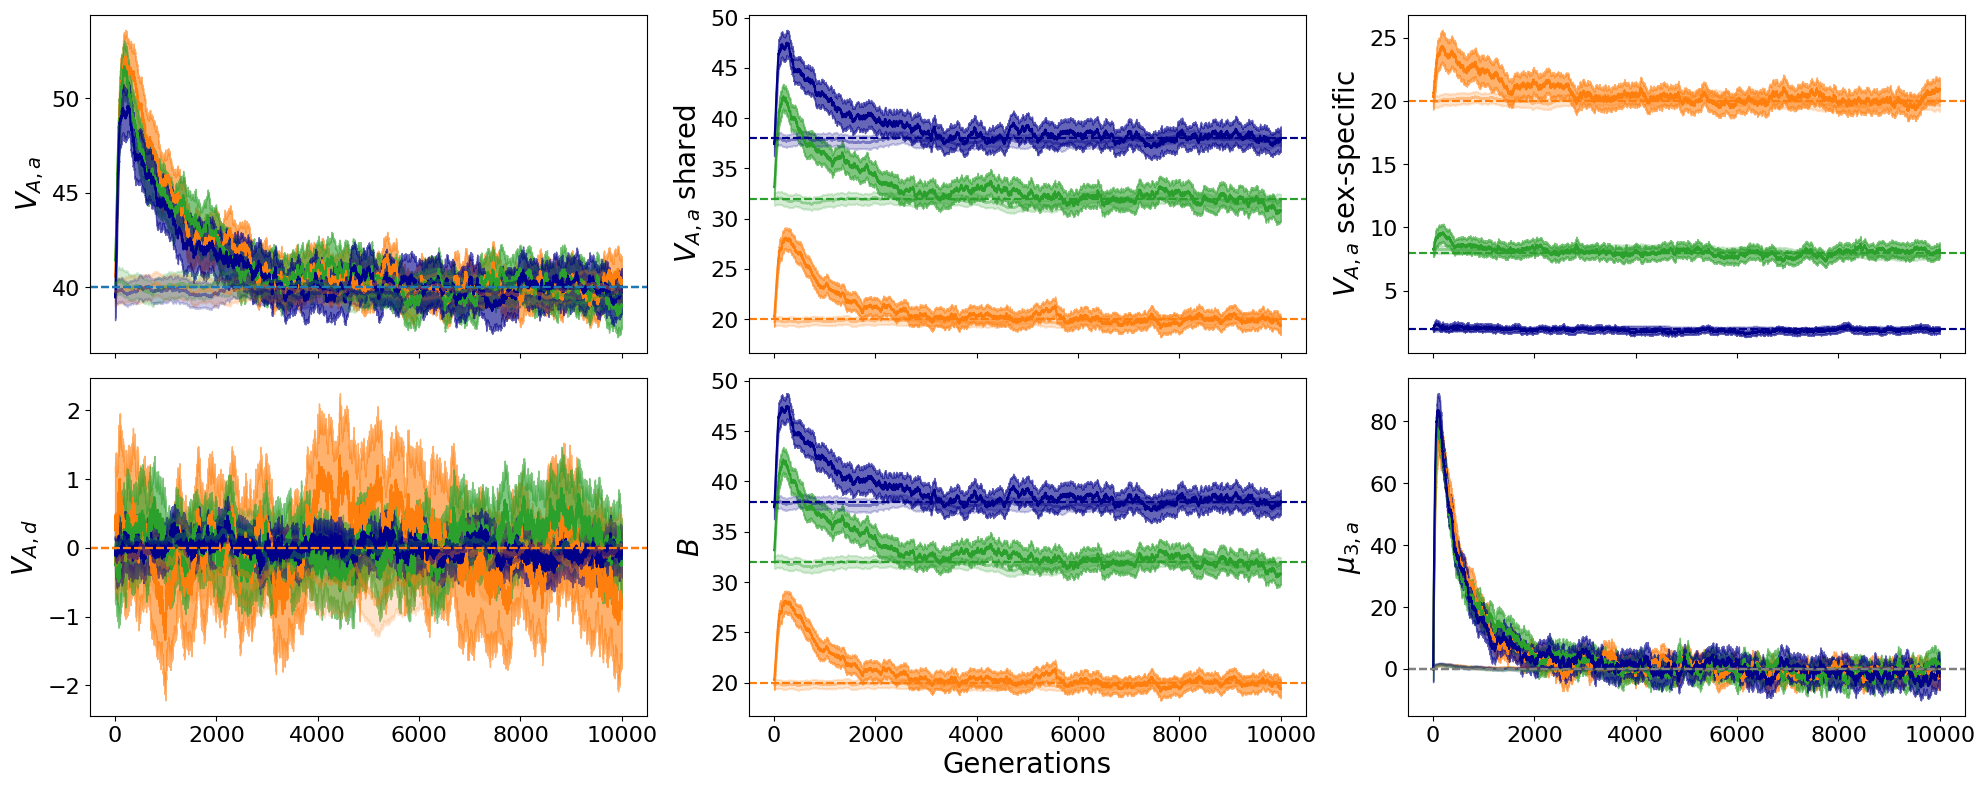

In [18]:
# Fig S9 top (concordant adaptation)

f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,8), sharex=True)

rfms=[0.5,0.8,0.95]
s1 = 22

plotall_scenarioA(s1, rfms, [ax1,ax2,ax3,ax4,ax5,ax6])

[ax.tick_params(labelsize=16) for ax in [ax1,ax2,ax3,ax4,ax5,ax6]];
f.tight_layout()

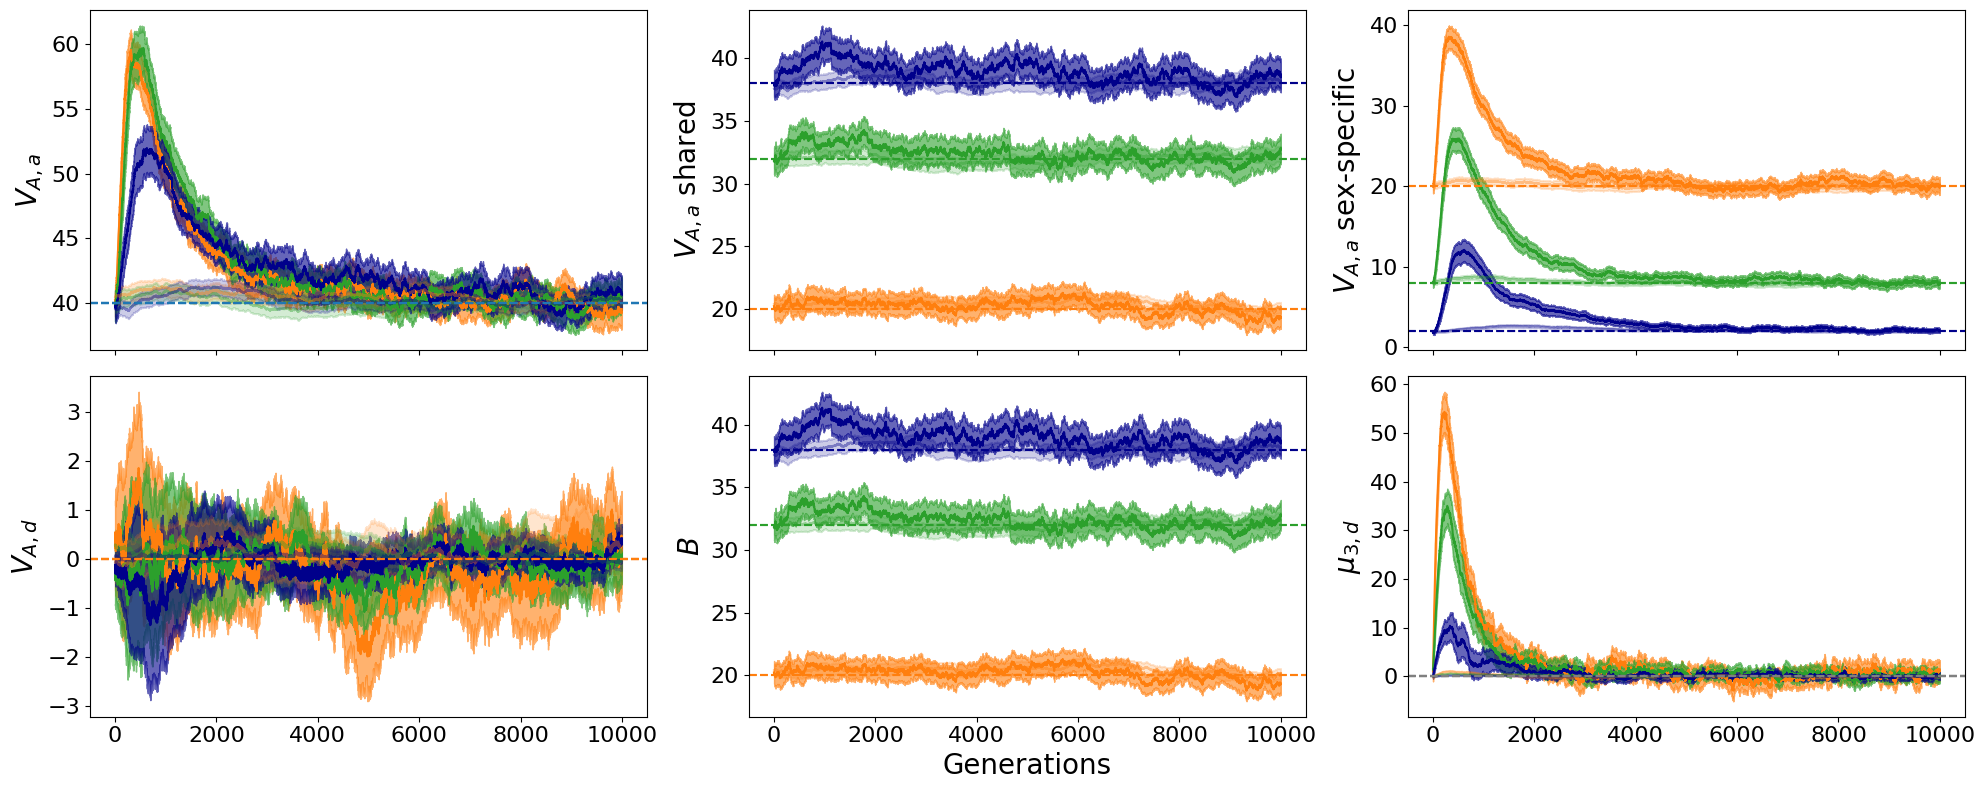

In [19]:
# Fig S9 bottom (dimorphic adaptation)

f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,8), sharex=True)

rfms=[0.5,0.8,0.95]
s2 = 55

plotall_scenarioD(s2, rfms, [ax1,ax2,ax3,ax4,ax5,ax6])

[ax.tick_params(labelsize=16) for ax in [ax1,ax2,ax3,ax4,ax5,ax6]];
f.tight_layout()

# Figure 3

Dynamics of dimorphic adaptation after divergent and convergent shifts in sex-specific optima.


In [20]:
''' Functions to plot sex-specific means after a shift in convergent and then divergent '''

# LEFT PLOTS (A, B)

# Function to load data (different from the one used so far)
def read_file (rfm, E2Ns):
    # rfm is parametrized in terms of q=1-rfm (again, for no relevant reason)
    q = "{:.3f}".format(1-rfm)
    # load simulation results
    #path = '../CLUSTER/ANA8_24_2/RESULTS/' # path for current results (rfm=0.5,0.8,0.95)
    path = 'RESULTS_FIG2-4/'
    res = pd.read_csv(path+'ana8inf_1000N_20Ngen_200Reps_'+q+'q_40VA_'+str(E2Ns)+'E2Ns_v1.csv')
    # remove some generations for nicer figures
    res = res.drop(index=list(range(9000))+list(range(20000,30000))+list(range(40000,50000)))
    return res

# Function to plot sex-specific trait means along time
def plot_means(rfm, E2Ns, ax):
    # get simulation results and aesthetics
    res = read_file(rfm, E2Ns)
    xs = np.linspace(-1000, len(res), len(res))
    c, a = get_c_a(rfm, 1)
    # plot the phenotypic averages with error bars
    ax.plot(xs, res.meanF, c=c, alpha=1)
    ax.plot(xs, res.meanM, c=c, alpha=0.4)
    ax.fill_between(xs, res.meanF-1.96*res.meanFstderr, res.meanF+1.96*res.meanFstderr, color=c, alpha=0.8)
    ax.fill_between(xs, res.meanM-1.96*res.meanMstderr, res.meanM+1.96*res.meanMstderr, color=c, alpha=0.2)
    # plot the optima as horizontal lines
    opt_DsqtVs = 0.25
    oF=-opt_DsqtVs*np.sqrt(2000)
    oM=opt_DsqtVs*np.sqrt(2000)
    ax.axhline(y=oF, c="black", ls=':')
    ax.axhline(y=oM, c="black", ls=':')

# Function to plot sex-specific averages for various rfm values
def plot_means_all (E2Ns, ax):
    plot_means(0.5, E2Ns, ax)
    plot_means(0.8, E2Ns, ax)
    plot_means(0.95, E2Ns, ax)
    ax.tick_params(labelsize=16)
    # plot vertical lines for the timepoints where we are measuring SD
    # (chosen by eye, to represent the dynamics during divergent and concordant dimorphic evolution)
    tpdiv = 600
    tpcon = 10800 
    ax.axvline(x=tpdiv, c='black', ls='--', lw=3)
    ax.axvline(x=tpcon, c='grey', lw=3)

# RIGHT PLOTS (C, D)

# Function to get the SD at the timepoint of divergent or convergent evolution
def get_divconv_rfm(divconv, rfm, E2Ns):
    if divconv=='div': tp = 600+1000
    elif divconv=='conv': tp = 10800+1000
    res = read_file(rfm, E2Ns)
    res.index = range(len(res))
    ress = res.loc[tp]
    SD = ress.absSD 
    yerr = 1.96*ress.absSDstderr
    
    return SD, yerr

# Function to plot a single value of SD (for a given rfm value)
def plot_single (xs, SDs, yerrs, divconv, ax):
    if divconv=='div': ls = '--'; m = 'o'; c = 'black'; l= 'divergent'
    elif divconv=='conv': ls = 'solid'; m = '^'; c = 'grey'; l = 'convergent'
    ax.errorbar(xs, SDs, yerr=yerrs, fmt=m, ms=10, c=c, linestyle=ls, label=l, lw=3)#, label=r'$|O_f-O_m|=%.1f$'%(2*oFi*np.sqrt(2000)))

# Function to plot SD vs rfm across all rfm values
def plot_divconv (E2Ns, ax):
    SDsD = []; yerrsD = []; SDsC = []; yerrsC = []; xs = []
    for rfm in [0.5,0.8,0.95]:
        SD, yerr = get_divconv_rfm ('div', rfm, E2Ns)
        SDsD += [SD]
        yerrsD += [yerr]
        SD, yerr = get_divconv_rfm ('conv', rfm, E2Ns)
        SDsC += [SD]
        yerrsC += [yerr]
        xs += [rfm]
    plot_single(xs, SDsD, yerrsD, 'div', ax)
    plot_single(xs, SDsC, yerrsC, 'conv', ax)
    ax.set_ylabel(r'$SD$', fontsize=20)
    ax.set_xlabel(r'$r_{fm}$', fontsize=20)
    ax.tick_params(labelsize=16) 

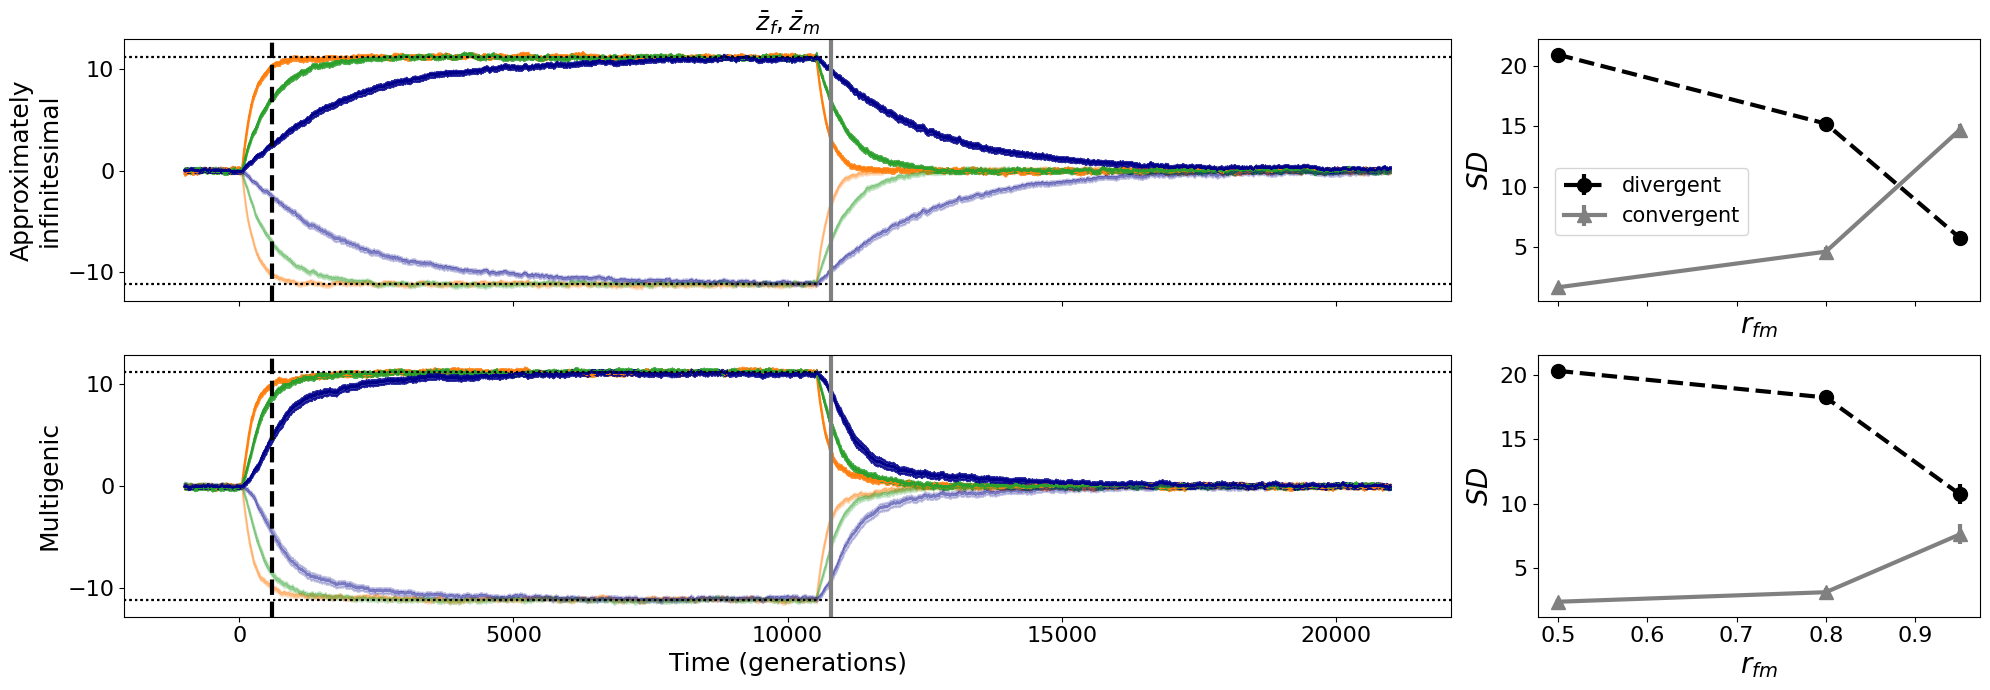

In [21]:
f, ((ax1,ax3),(ax2,ax4)) = plt.subplots(2,2, figsize=(20,7), sharex='col', gridspec_kw={'width_ratios': [3, 1]})

plot_means_all(1, ax1)
plot_means_all(16, ax2)
plot_divconv(1, ax3)
plot_divconv(16, ax4)

ax1.set_title(r'$\bar z_f, \bar z_m$', fontsize=18)
ax2.set_xlabel('Time (generations)', fontsize=18)
ax1.set_ylabel('Approximately\ninfinitesimal', fontsize=18)
ax2.set_ylabel('Multigenic', fontsize=18)


ax3.legend(fontsize=15, bbox_to_anchor=(0.5, 0.55))
f.tight_layout()

# Figure 4 A-B

Evolution of sex-specific trait means, variances, covariance and intersex correlation along time and after a divergent and then convergent shift in sex-specific optima. 

In [22]:
# Function to plot the relevant variables along time
def plot_fig4 (res, ana, ax1,ax2,ax3,ax4):
    # plot sex-specific means
    ax1.plot(res.meanF, c="lightcoral", label='male')
    ax1.plot(res.meanM, c="darkgreen", label='female')
    ax1.fill_between(range(len(res)), res.meanF-res.meanFstderr, res.meanF+res.meanFstderr, color='lightcoral', alpha=0.5)
    ax1.fill_between(range(len(res)), res.meanM-res.meanMstderr, res.meanM+res.meanMstderr, color='darkgreen', alpha=0.5)
    ax1.axhline(y=oF, c="black", ls=':')
    ax1.axhline(y=oM, c="black", ls=':')

    # plot sex-specific variances
    ax2.plot(res.varM, c="darkgreen", label="female")
    ax2.plot(res.varF, c="lightcoral", label="male")
    ax2.fill_between(range(len(res)), res.varF-res.varFstderr, res.varF+res.varFstderr, color='lightcoral', alpha=0.5)
    ax2.fill_between(range(len(res)), res.varM-res.varMstderr, res.varM+res.varMstderr, color='darkgreen', alpha=0.5)

    # plot covariance
    ax3.plot(res.covar, c="saddlebrown", label="covar G")
    ax3.fill_between(range(len(res)), res.covar-res.covarstderr, res.covar+res.covarstderr, color='saddlebrown', alpha=0.5)

    # plot intersex correlation
    ax4.axhline(y=1, c='black')
    ax4.plot(res.rFM, c='black', label='rFM G')
    ax4.fill_between(range(len(res)), res.rFM-res.rFMstderr, res.rFM+res.rFMstderr, color='black', alpha=0.5)

    # plot the expected values as horizontal lines
    ax2.axhline(y=ana.calculate_VA(), c='black', ls='--')
    ax3.axhline(y=ana.calculate_covar(), c='black', ls='--')
    ax4.axhline(y=ana.calculate_rFM(), c='black', ls='--')

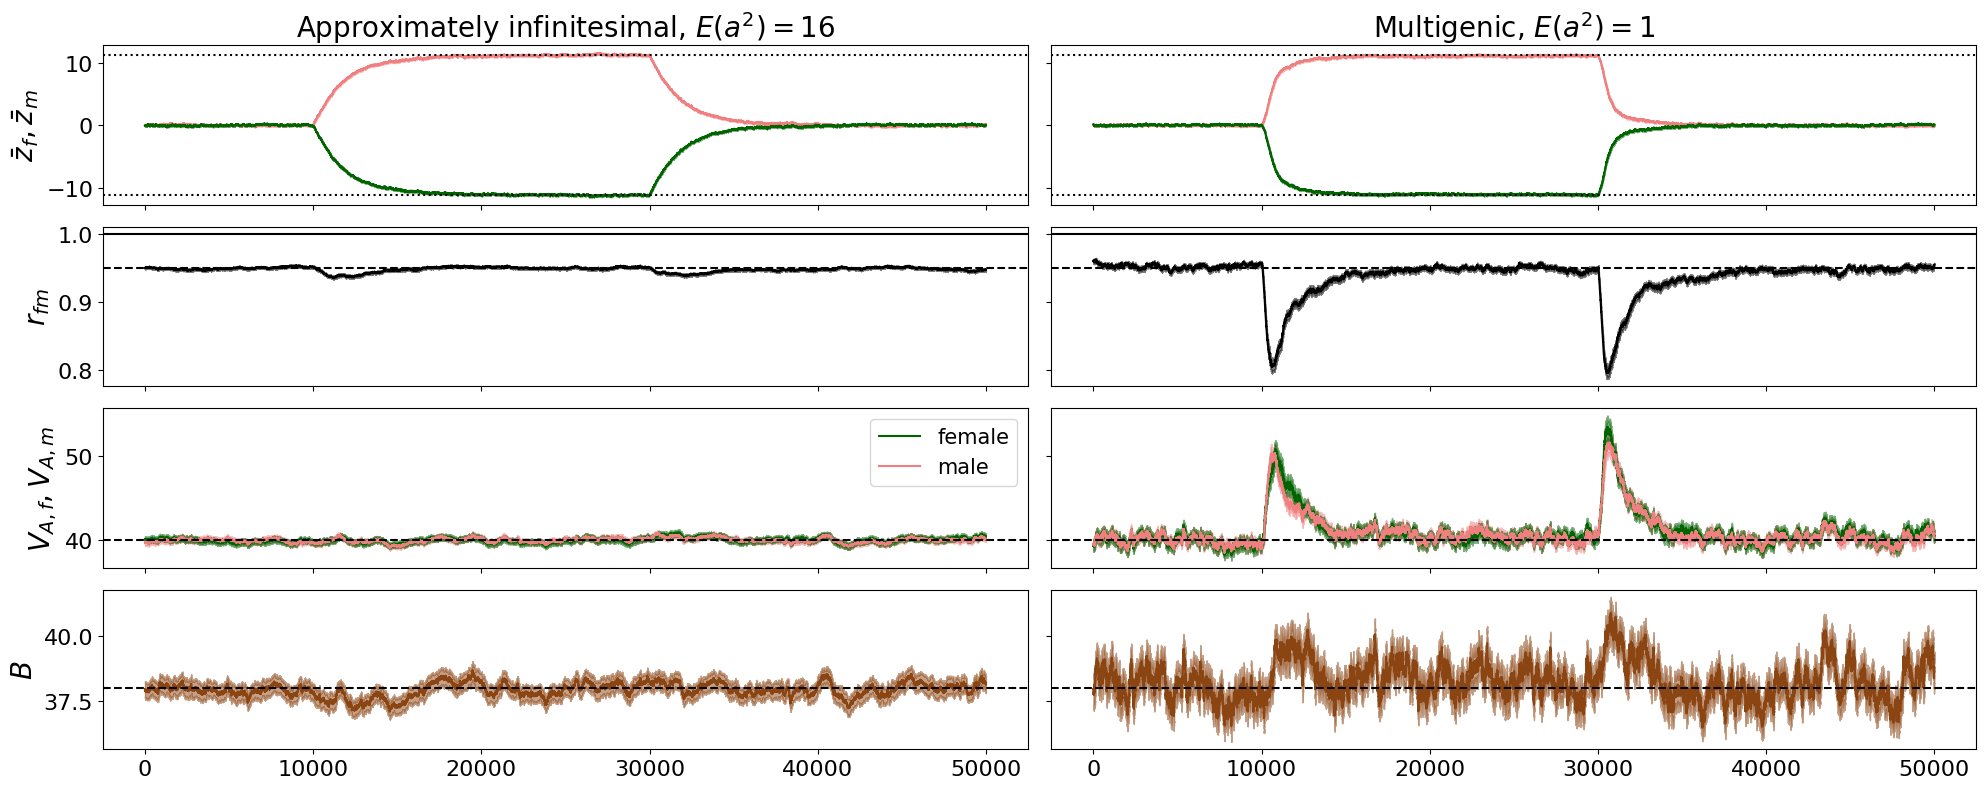

In [23]:
N=1000; U=0.01
oi = 0.25
oF=oi*np.sqrt(2*N)
oM=-oi*np.sqrt(2*N)
generations = 2*N
rfm = 0.95
q = 1-rfm
VA = 40

#path = '../CLUSTER/ANA8_24_2/RESULTS/' # path for current results (rfm=0.5,0.8,0.95)
path = 'RESULTS_FIG2-4/'
res1 = pd.read_csv(path+'ana8inf_1000N_20Ngen_200Reps_%.3fq_40VA_1E2Ns_v1.csv'%q)
res16 = pd.read_csv(path+'ana8inf_1000N_20Ngen_200Reps_%.3fq_40VA_16E2Ns_v1.csv'%q)

f, ((ax1,ax5),(ax4,ax8),(ax2,ax6),(ax3,ax7)) = plt.subplots(4,2, figsize=(20,8), sharex=True, sharey='row')#, sharey=True, sharex=True)
#f, ((ax1,ax5),(ax4,ax8),(ax2,ax6),(ax3,ax7)) = plt.subplots(4,2, figsize=(20,8), sharey=True, sharex=True)

ana16 = initialize_analytics_fromVA(N, VA, rfm, E2Ns, oF, oM)
ana1 = initialize_analytics_fromVA(N, VA, rfm, E2Ns, oF, oM)

plot_fig4(res1, ana1, ax1,ax2,ax3,ax4)
plot_fig4(res16, ana16, ax5,ax6,ax7,ax8)

ax1.set_ylabel(r'$\bar z_f, \bar z_m$', fontsize=20)
ax4.set_ylabel('$r_{fm}$', fontsize=20)
ax2.set_ylabel('$V_{A,f}, V_{A,m}$', fontsize=20)
ax3.set_ylabel('$B$', fontsize=20)

ax1.set_title(r'Approximately infinitesimal, $E(a^2)=16$', fontsize=20)
ax5.set_title(r'Multigenic, $E(a^2)=1$', fontsize=20)

ax2.legend(fontsize=15)
[ax.tick_params(labelsize=16) for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]];

f.tight_layout()

____

# Empirical integrals 

'Empirical integrals' correspond to the average across 10N (or 5N generations in the 'half' option) after optima shift of the target variable (see the python script 'script_fig2-4.py' for more details on how this is calculated).

(Figure 4C-E and S12)

In [24]:
''' Functions to plot the 'empirical integral'.
Argument fullhalf:
    - fullhalf=='full': average across 10N generations
    - fullhalf=='half': average across 5N generations
Argument at0:
    - if: at0==1: the respective analytical value has been subtracted from the average of target variable, so its value is close to 0
    - elif at0==0: the 'raw' average target variable
'''

# Function to plot the empirical integrals

def plot_integralSE_sample (scenario, rfm, E2Ns, ax1,ax2,ax3, at0=1, fullhalf='half'):
    # load simulation results
    res = open_file(scenario, rfm, E2Ns)
    # set aesthetics
    c,a = get_c_a(rfm, E2Ns)
    if E2Ns==16: m='w'
    elif E2Ns==1: m=c
    ms = 15

    # plot the 'empirical integrals'
    if at0==0: # 'normalized' target variable
        if fullhalf=='full': # average across 10N generations after the shift
            ax1.errorbar(scenario, res.intV[0], yerr=res.intV_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
            ax2.errorbar(scenario, res.intB[0], yerr=res.intB_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
            ax3.errorbar(scenario, res.intrFM[0]/(2-res.intrFM[0]), yerr=res.intrFM_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
        elif fullhalf=='half': # average across 5N generations after the shift
            ax1.errorbar(scenario, res.intV_half[0], yerr=res.intV_half_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
            ax2.errorbar(scenario, res.intB_half[0], yerr=res.intB_half_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
            ax3.errorbar(scenario, res.intrFM_half[0]/(2-res.intrFM_half[0]), yerr=res.intrFM_half_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
    elif at0==1: # 'raw' target variable
        if fullhalf=='full': # average across 10N generations after the shift
            ax1.errorbar(scenario, res.intV0[0], yerr=res.intV0_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
            ax2.errorbar(scenario, res.intB0[0], yerr=res.intB0_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
            ax3.errorbar(scenario, res.intrFM0[0]/(2-res.intrFM0[0]), yerr=res.intrFM0_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
        elif fullhalf=='half': # average across 5N generations after the shift
            ax1.errorbar(scenario, res.intV0_half[0], yerr=res.intV0_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
            ax2.errorbar(scenario, res.intB0_half[0], yerr=res.intB0_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
            ax3.errorbar(scenario, res.intrFM0_half[0]/(2-res.intrFM0_half[0]), yerr=res.intrFM0_se[0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')

# Function to plot the empirical integrals across all parameter combinations
# by default at0=0 and fullhalf='half'

def plot_integralSE_all (scenarios, ax1,ax2,ax3, at0=0, fullhalf='half'):
    rfms=[0.5, 0.8, 0.95]
    for scen in scenarios:
        plot_integralSE_sample (scen, rfms[0], 1, ax1,ax2,ax3, at0, fullhalf)
        plot_integralSE_sample (scen, rfms[1], 1, ax1,ax2,ax3, at0, fullhalf)
        plot_integralSE_sample (scen, rfms[2], 1, ax1,ax2,ax3, at0, fullhalf)
        plot_integralSE_sample (scen, rfms[0], 16, ax1,ax2,ax3, at0, fullhalf)
        plot_integralSE_sample (scen, rfms[1], 16, ax1,ax2,ax3, at0, fullhalf)
        plot_integralSE_sample (scen, rfms[2], 16, ax1,ax2,ax3, at0, fullhalf)
        
    #plot analytical estimates of the target variables
    N = 1000; VA = 40; 
    alphas = [0.2, 0.5, 1]
    for i in range(len(rfms)):
        c,a = get_c_a(rfms[i], 1)
        an = initialize_analytics_fromVA (N, VA, rfms[i], 1)
        if at0==0:
            ax1.axhline(y=an.calculate_Va(), c=c, ls='--', alpha=a)
            ax2.axhline(y=an.calculate_covar(), c=c, ls='--', alpha=a)
            ax3.axhline(y=an.calculate_rFM()/(2-an.calculate_rFM()), c=c, ls='--', alpha=a)
            #print (a.calculate_rFM()/(2-a.calculate_rFM()))
        elif at0==1:
            [ax.axhline(y=0, c='black', ls='--') for ax in [ax1,ax2,ax3]]

    # aesthetics
    if at0==1:
        ax1.set_ylabel(r'$\frac{1}{5N}\sum^{5N} (V_{A,a} - V_{A,a,0})$', fontsize=30)
        ax2.set_ylabel(r'$\frac{1}{5N}\sum^{5N} (B-B_0)$', fontsize=30)
        ax3.set_ylabel(r'$\frac{1}{5N}\sum^{5N} (r_{fm}-r_{fm,0})$', fontsize=30)
    elif at0==0:
        ax1.set_ylabel(r'$\frac{1}{5N}\sum^{5N} V_{A,a}$', fontsize=30)
        ax2.set_ylabel(r'$\frac{1}{5N}\sum^{5N} B$', fontsize=30)
        ax3.set_ylabel(r'$\frac{1}{5N}\sum^{5N} r_{fm}$', fontsize=30)
    [ax.set_xlabel('Scenario', fontsize=20) for ax in [ax1,ax2,ax3]]
    [ax.tick_params(labelsize=20) for ax in [ax1,ax2,ax3]]
    [ax.set_xticks([11,22,33,44,55,66],
           [r'$\Lambda_{a,S}$', r'$\Lambda_{a,M}$', r'$\Lambda_{a,L}$', 
            r'$\Lambda_{d,S}$', r'$\Lambda_{d,M}$', r'$\Lambda_{a,L}$']) for ax in [ax1,ax2,ax3]]

    
# Function to plot the empirical integrals of the variables considering contribution of only shared or sex-specific mutations

def plot_integralSE_sharedspec_sample (sharedspec, scenario, rfm, E2Ns, ax, at0=1, fullhalf='half'):
    # load simulation results
    res = open_file(scenario, rfm, E2Ns)
    # get aesthetics
    c,a = get_c_a(rfm, E2Ns)
    if E2Ns==16: m='w'
    elif E2Ns==1: m=c
    ms = 15

    # Plot empirical integrals
    if at0==0: # 'normalized' target variable
        if fullhalf=='full': # average across 10N generations after the shift
            ax.errorbar(scenario, res['intV'+sharedspec][0], yerr=1.96*res['intV'+sharedspec+'_se'][0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
        elif fullhalf=='half': # average across 5N generations after the shift
            ax.errorbar(scenario, res['intV'+sharedspec+'_half'][0], yerr=1.96*res['intV'+sharedspec+'_half_se'][0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
    elif at0==1: # 'raw' target variable
        if fullhalf=='full': # average across 10N generations after the shift
            ax.errorbar(scenario, res['intV0'+sharedspec][0], yerr=1.96*res['intV0'+sharedspec+'_se'][0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')
        elif fullhalf=='half': # average across 5N generations after the shift
            ax.errorbar(scenario, res['intV0'+sharedspec+'_half'][0], yerr=1.96*res['intV0'+sharedspec+'_half_se'][0], mfc=m, c=c, alpha=a, markersize=ms, marker='o')

# Function to plot the empirical integrals across all parameter combinations

def plot_integralSE_sharedspec_all (sharedspec, scenarios, ax, at0=0, fullhalf='half'):
    rfms=[0.5, 0.8, 0.95]
    for scen in scenarios:
        plot_integralSE_sharedspec_sample (sharedspec, scen, rfms[0], 1, ax, at0, fullhalf)
        plot_integralSE_sharedspec_sample (sharedspec, scen, rfms[1], 1, ax, at0, fullhalf)
        plot_integralSE_sharedspec_sample (sharedspec, scen, rfms[2], 1, ax, at0, fullhalf)
        plot_integralSE_sharedspec_sample (sharedspec, scen, rfms[0], 16, ax, at0, fullhalf)
        plot_integralSE_sharedspec_sample (sharedspec, scen, rfms[1], 16, ax, at0, fullhalf)
        plot_integralSE_sharedspec_sample (sharedspec, scen, rfms[2], 16, ax, at0, fullhalf)
        
    #plot analytical estimates of the target variables
    N = 1000; VA = 40; 
    alphas = [0.2, 0.5, 1]
    for rfm in rfms:
        c,a = get_c_a(rfm, 1)
        an = initialize_analytics_fromVA (N, VA, rfm, 1)
        if at0==0:
            if sharedspec=='shared': ax.axhline(y=an.calculate_Va()*rfm, c=c, ls='--')
            elif sharedspec=='spec': ax.axhline(y=an.calculate_Va()*(1-rfm), c=c, ls='--')
        elif at0==1:
            ax.axhline(y=0, c='black', ls='--')

    # aesthetics
    if at0==1:
        if sharedspec=='shared': ax.set_ylabel(r'$\frac{1}{5N}\sum^{5N} (V_{A,a} - V_{A,a,0})$   shared', fontsize=25) #ax.set_ylabel(r'$\sum^{5N} V_{A,a}}/5N$ shared (units of $\delta^2$)', fontsize=20)
        if sharedspec=='spec': ax.set_ylabel(r'$\frac{1}{5N}\sum^{5N} V_{A,a} - V_{A,a,0})$   sex-specific', fontsize=25)
    elif at0==0:
        if sharedspec=='shared': ax.set_ylabel(r'$\frac{1}{5N}\sum^{5N} V_{A,a} - V_{A,a,0})$   shared', fontsize=25) #ax.set_ylabel(r'$\sum^{5N} V_{A,a}}/5N$ shared (units of $\delta^2$)', fontsize=20)
        if sharedspec=='spec': ax.set_ylabel(r'$\frac{1}{5N}\sum^{5N} V_{A,a} - V_{A,a,0}$   sex-specific', fontsize=25)
    ax.set_xlabel('Scenario', fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xticks([11,22,33,44,55,66], [r'$\Lambda_{a,S}$', r'$\Lambda_{a,M}$', r'$\Lambda_{a,L}$', r'$\Lambda_{d,S}$', r'$\Lambda_{d,M}$', r'$\Lambda_{a,L}$'])

## Figure 4C-E

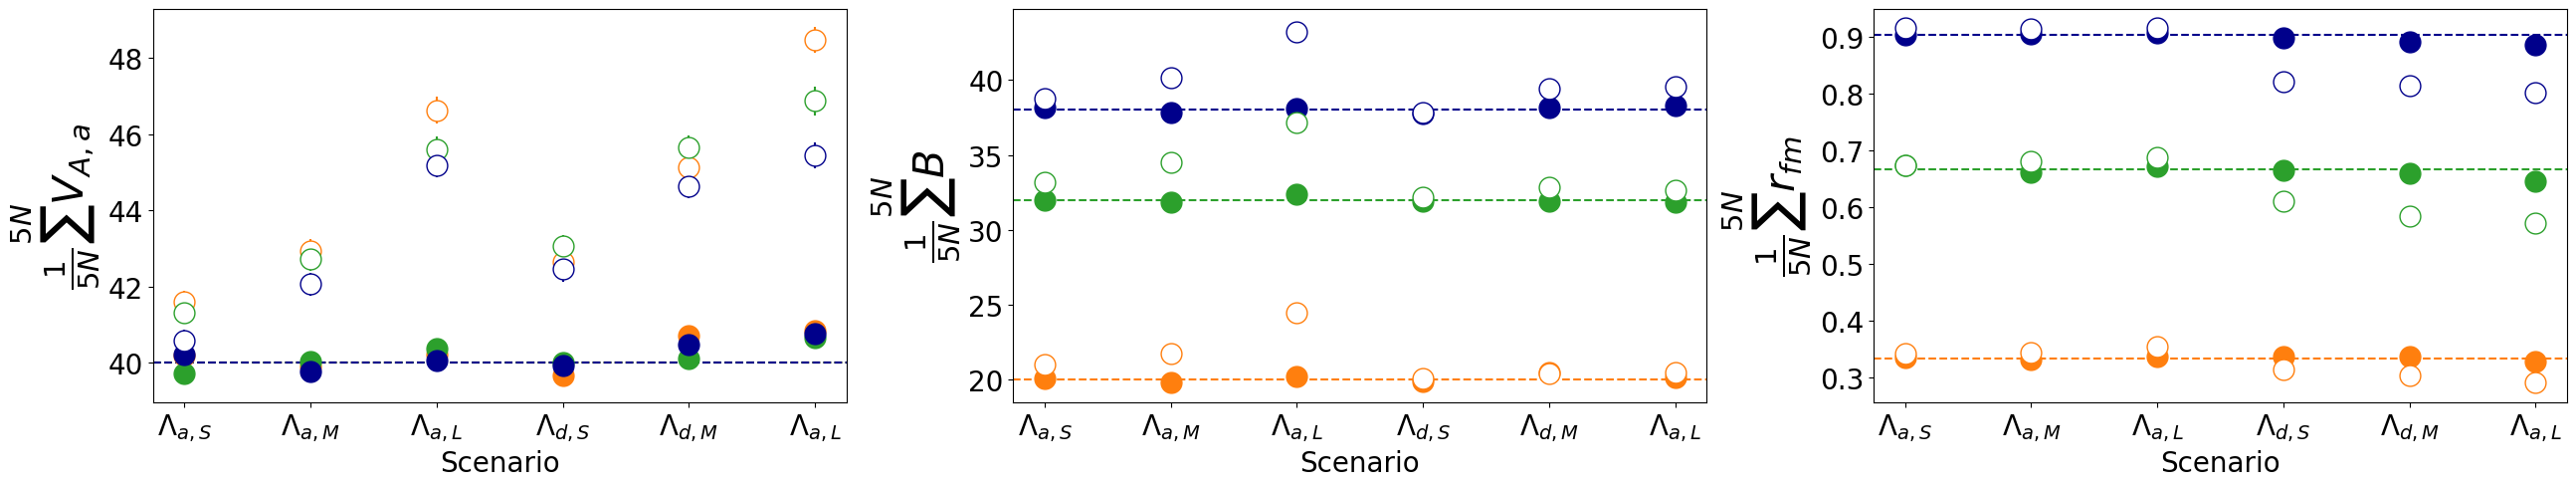

In [25]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(26,5))

plot_integralSE_all ([11,22,33,44,55,66], ax1,ax2,ax3, 0, 'half')

f.tight_layout()

## Figure S12

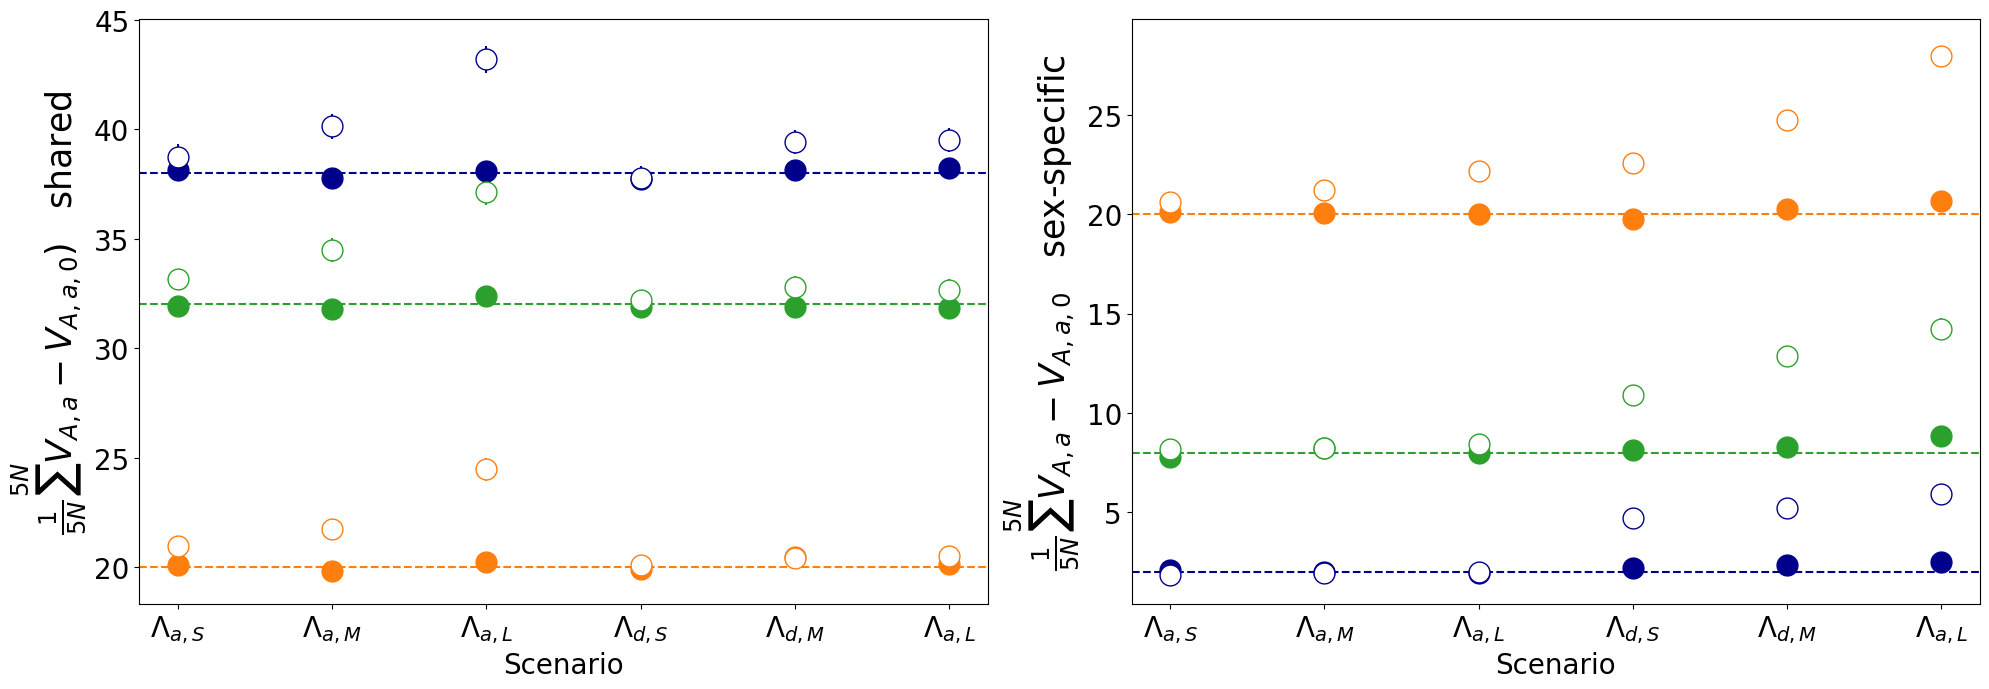

In [26]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,7))

plot_integralSE_sharedspec_all ('shared', [11,22,33,44,55,66], ax1, 0, 'half')
plot_integralSE_sharedspec_all ('spec', [11,22,33,44,55,66], ax2, 0, 'half')


f.tight_layout()

# Figure 4F

In [27]:
'''These functions plot the difference between SD before and after the shift versus 
the difference between the empirical rfm integral (across 5N generations after the shift) and the equilibrium rfm value
for both divergent and convergent adaptation 
(with a multigenic genetic architecture, as the decrease in rfm does not occur in the approximately infinitesimal case)'''

# Get expected SD given the scenario
def get_SDfromScenario (scenario):
    # get the coefficients from the scenario
    if scenario==11: ofi=0.15; omi=0.15
    elif scenario==22: ofi=0.25; omi=0.25
    elif scenario==33: ofi=0.50; omi=0.50
    elif scenario==44: ofi=0.15; omi=-0.15
    elif scenario==55: ofi=0.25; omi=-0.25
    elif scenario==66: ofi=0.50; omi=-0.50
    
    N=1000
    # get sex-specific optima from the coefficients
    oF = float(ofi)*np.sqrt(2*N)
    oM = float(omi)*np.sqrt(2*N)
    # The expected SD before the shift (when opt_f=opt_m) is 2*np.sqrt(2/np.pi), see Equation \ref{eq:ESDfinal} (33)
    return abs(oF-oM)-2*np.sqrt(2/np.pi)

# The empirical integral
def get_rFMfromres (res, an):
    #intrFM0_half corresponds to the sum across 5N generations after the shift of the difference between observed and expected (equilibrium value of) rfm
    return res.intrFM_half[0] - an.calculate_rFM()

# Function to plot shift in SD vs empirical rfm integral
def plot_h2 (rfm, E2Ns, divconv, ax):
    # get aesthetics
    c, a = get_c_a(rfm, 1)
    if E2Ns == 1: m = c; ls='--'
    elif E2Ns == 16: m='w'; ls='solid'
    SD=[]; rFM=[]
    # initialize the analytics
    an = initialize_analytics_fromVA (1000, 40, rfm, E2Ns)
    # get the relevant variables for each scenario
    for scenario in [44,55,66]:
        # load simulation data
        res = open_file(scenario, rfm, E2Ns)
        # get the difference in SD before and after the shift
        SD += [get_SDfromScenario(scenario)]
        # get the sum
        rFM += [get_rFMfromres(res, an)]
    # plot them for divergent or convergent adaptation
    if divconv == 'div':
        ax.plot(rFM, SD, marker='o', mfc=m, ls=ls, c=c, ms=10, lw=3)#, fmt=m, c=c, alpha=a, markersize=ms)
    elif divconv == 'conv':
        ax.plot(rFM, -1*np.array(SD), marker='o', mfc=m, ls=ls, c=c, ms=10, lw=3)

# Function to plot the relationship across conditions/parameters

def plot_h2_all (rfms, E2Ns, ax1,ax2):
    plot_h2(rfms[0], E2Ns, 'div', ax1)
    plot_h2(rfms[1], E2Ns, 'div', ax1)
    plot_h2(rfms[2], E2Ns, 'div', ax1)
    plot_h2(rfms[0], E2Ns, 'conv', ax2)
    plot_h2(rfms[1], E2Ns, 'conv', ax2)
    plot_h2(rfms[2], E2Ns, 'conv', ax2)

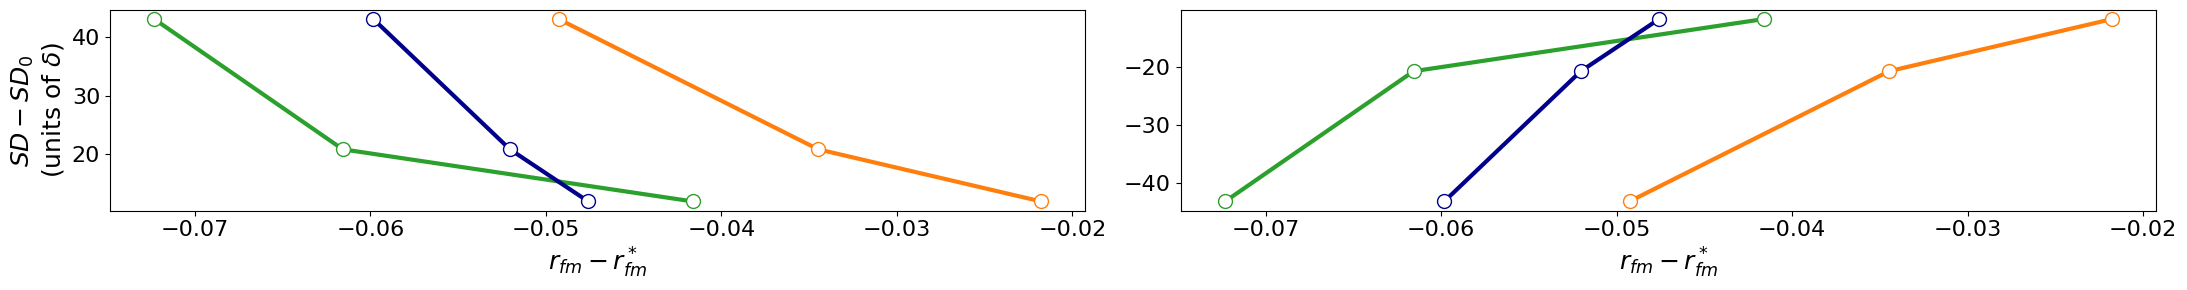

In [28]:
# Make the figure

f, (ax1,ax2) = plt.subplots (1,2, figsize=(22,3))

# plot for 3 values of rfms and multigenic genetic architecture
rfms=[0.5,0.8,0.95]
plot_h2_all(rfms, 16, ax1, ax2)

ax1.set_ylabel('$SD-SD_0$\n(units of $\delta$)', fontsize=18)
ax1.set_xlabel(r'$r_{fm}-r^*_{fm}$', fontsize=18)
ax2.set_xlabel(r'$r_{fm}-r^*_{fm}$', fontsize=18)
[ax.tick_params(labelsize=16) for ax in [ax1,ax2]];

f.tight_layout()